In [2]:
#packages
import numpy as np
import scipy.linalg as la
import networkx as nx 
from functools import reduce
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl 
import pickle
from joblib import Parallel, delayed

mpl.rc('font', size=10)
mpl.rc('legend', fontsize=10) 
mpl.rc('legend', numpoints=1)
mpl.rc('legend', handlelength=1.2)
mpl.rc('legend', frameon=False)
#mpl.rc('xtick.major', pad=7)
#mpl.rc('xtick.minor', pad=7)
mpl.rc('lines', lw=1)
mpl.rc('xtick',labelsize =8) 
mpl.rc('ytick',labelsize =8)


plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Complete Graph Hamiltonian

In [4]:

def H_CG(N, gamma, w, kappa):
    """
    Generate the Hamiltonian for search on the Complete Graph with a sink at target site.
    
    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        w (int): Target node/site location; dynamics invariant under choice of w.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.
        
    Returns:
        np.ndarray: The resulting Hamiltonian in matrix form.
    """
    ket_s = np.ones((N, 1)) / np.sqrt(N) # Initial state (uniform superposition)
    H = -gamma * N * ket_s @ ket_s.T.conj() # Hamiltonian matrix of complete graph
    H = H.astype(complex)
    H[w, w] -= (1 + 1j * kappa)  # Target site
    return H.astype(complex)

## Eigenvalues and eigenvectors (theoretically)

In [5]:


def lambda_pm(N,gamma,kappa):

    """
    Compute the analytical expresion of the eigenvalues in the two dimensional subspace.

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        lambda_plus (float): Eigenenergy of the form a + b
        lambda_minus (float): Eigenenergy of the form a - b
    """
    

    lambda_plus  = -(gamma*N + 1 + 1.0j*kappa)/2  + np.sqrt(((gamma*N + 1 + 1.0j*kappa)/2)**2 - (gamma*N - gamma)*(1 + 1.0j*kappa))
    lambda_minus = -(gamma*N + 1 + 1.0j*kappa)/2  - np.sqrt(((gamma*N + 1 + 1.0j*kappa)/2)**2 - (gamma*N - gamma)*(1 + 1.0j*kappa))

    return lambda_plus,lambda_minus

def imag_lambda_pm(N,gamma,kappa):

    """
    Compute the analytical expresion of the imaginary part of the eigenvalues in the two dimensional subspace.

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        imag_lambda_plus (float): Imaginary part of eigenvalue lambda_plus
        imag_lambda_minus (float): Imaginary part of eigenvalue lambda_minus
    """
    
   # a  = ((gamma*N + 1)**2 - kappa**2)/4 - (gamma*N - gamma)
    a = 1/4 + gamma - N*gamma/2 + N*N*gamma*gamma/4 - kappa*kappa/4
    b  = kappa/2 + gamma*kappa - N*gamma*kappa/2
    mod_z = (1/4)*np.sqrt(4*(kappa*kappa)*(-1 + (N-2)*gamma)**2 + (-1 +2*(N - 2)*gamma - N*N*gamma*gamma + kappa*kappa)**2)
    #mod_z = np.sqrt(a**2 + b**2)

    imag_lambda_plus = - kappa/2 + np.sign(b)*np.sqrt((mod_z - a)/2)
    imag_lambda_minus = - kappa/2 - np.sign(b)*np.sqrt((mod_z - a)/2)

    return imag_lambda_plus, imag_lambda_minus

def lambdaR(N,gamma,kappa):

    """
    Compute the analytical expresion of the right eigenvectors in the two dimensional subspace.

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        lambdaR_plus (np.ndarray): Right eigenvector corresponding to eigenvalue lambda_plus (column vector)
        lambdaR_minus (np.ndarray): Right eigenvector corresponding to eigenvalue lambda_minus (column vector)
    """   

    lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

    a_plus = (- lambda_plus - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_plus = 1
   
    lambdaR_plus = np.array([a_plus,b_plus])

    a_minus = (- lambda_minus - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_minus = 1
    lambdaR_minus = np.array([a_minus,b_minus])

    return lambdaR_plus, lambdaR_minus


def lambdaL(N,gamma,kappa):

    """
    Compute the analytical expresion of the left eigenvectors in the two dimensional subspace.

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        lambdaL_plus (np.ndarray): Left eigenvector corresponding to eigenvalue lambda_plus (column vector)
        lambdaL_minus (np.ndarray): Left eigenvector corresponding to eigenvalue lambda_minus (column vector)
    """  

    lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

    a_plus = (- np.conj(lambda_plus) - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_plus = 1
   
    lambdaL_plus = np.array([a_plus,b_plus])

    a_minus = (- np.conj(lambda_minus) - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_minus = 1
    lambdaL_minus = np.array([a_minus,b_minus])

    return lambdaL_plus, lambdaL_minus



## Overlaps

In [6]:
def overlap(N,gamma,kappa):

    """
    Compute the analytical expresion of the overlaps with initial uniform superposition state. The overlaps corresponds to each term
    in the analytical expression of survival probability (see text for more details). 

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        overlap_plus (float): Overlap correspond to the decay rate governed by Im[lambda_plus].
        overlap_minus (float): Overlap correspond to the decay rate governed by Im[lambda_minus].
        overlap_pm (complex): Overlap correspond to the term having cross terms from both eigenvalues.
    """  

    lambdaR_plus, lambdaR_minus = lambdaR(N,gamma,kappa)
    lambdaL_plus, lambdaL_minus = lambdaL(N,gamma,kappa)

    #initial state
    ket_s = np.array([1.0/np.sqrt(N) ,np.sqrt((N-1)/N)])

    overlap_plus =(1/np.abs(np.vdot(lambdaL_plus,lambdaR_plus))**2)*np.vdot(lambdaR_plus,lambdaR_plus)*np.abs(np.vdot(ket_s, lambdaL_plus))**2

    overlap_minus =(1/np.abs(np.vdot(lambdaL_minus,lambdaR_minus))**2)*np.vdot(lambdaR_minus,lambdaR_minus)*np.abs(np.vdot(ket_s, lambdaL_minus))**2

    #overlap_pm = (1/(np.vdot(lambdaR_plus,lambdaL_plus)*np.vdot(lambdaL_minus,lambdaR_minus)))*np.vdot(ket_s,lambdaL_plus)*np.vdot(lambdaL_minus,ket_s)*np.vdot(lambdaR_plus, lambdaR_minus)
    #overlap_mp = (1/(np.vdot(lambdaR_minus,lambdaL_minus)*np.vdot(lambdaL_plus,lambdaR_plus)))*np.vdot(ket_s,lambdaL_minus)*np.vdot(lambdaL_plus,ket_s)*np.vdot(lambdaR_minus, lambdaR_plus)
    overlap_pm = (1/(np.vdot(lambdaR_plus,lambdaL_plus)*np.vdot(lambdaL_minus,lambdaR_minus)))*np.vdot(ket_s,lambdaL_plus)*np.vdot(lambdaL_minus,ket_s)*np.vdot(lambdaR_plus, lambdaR_minus)

    return overlap_plus, overlap_minus,overlap_pm

## Survival Probability theory without reset

In [53]:
def surv_prob_theory_total(Tcutoff, dt, N, gamma, kappa):

    """
    Compute the survival probability as a function of time analytically in two-dimensional basis without any reset.
    
    Args:
        Tcutoff (float): Cutoff time for the dynamics.
        dt (float): Discretization of time into time steps of duration dt.
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.
        
    Returns:
        np.ndarray: Survival probabilities.
    """
 
    m = int(Tcutoff / dt)  # Number of time steps, each with duration dt

    #eigenvalues
    lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

    #overlaps 
    overlap_plus, overlap_minus,overlap_pm = overlap(N,gamma,kappa)
   
    s_prob = np.zeros(m) # Initialize array

    for j in range(m): 
        first_term  = np.exp(-1.0j*(lambda_plus - np.conj(lambda_plus))*j*dt)*overlap_plus
        second_term = np.exp(-1.0j*(lambda_minus - np.conj(lambda_minus))*j*dt)*overlap_minus
        third_term  = 2*np.real(np.exp(-1.0j*(lambda_minus - np.conj(lambda_plus))*j*dt)*overlap_pm)

        s_prob[j] = first_term + second_term +third_term


    return s_prob

## Find decay time in the survival probability 

In [55]:
def find_transition_point(arr, dt,tp): 
    """
    Find the first time index where the survival probability (SP) drops below tp.
    
    Args:
        arr (numpy array): Array of survival probability values.
        dt (float): Discretization of time into time steps of duration dt.
        
    Returns:
        float: Time at which SP drops below the value of tp.
    """
    idx = np.where(arr <= tp)[0]
    return idx[0] * dt if len(idx) > 0 else np.inf  # Return first occurrence or 0

## Decay time to 0.001

In [56]:
# Parameters
N = 500  # System size
Tcutoff = 30*np.sqrt(N)
dt = 0.05
kappa_vals = np.linspace(0.01,0.2 , 100)
gamma_vals = np.linspace(0.8/N, 1.2/N, 100)

# Storage Arrays
T_decay0p5_theory_single = np.zeros((len(gamma_vals), len(kappa_vals)))
s_prob_arr_theory = np.zeros((len(gamma_vals), len(kappa_vals), int(Tcutoff / dt)))

# Compute Survival Probabilities and Transition Points
for gg, gamma in tqdm(enumerate(gamma_vals), total=len(gamma_vals)):
    for kk, kappa in enumerate(kappa_vals):
        s_prob_theory = surv_prob_theory_total(Tcutoff, dt, N, gamma, kappa)
        s_prob_arr_theory[gg, kk] = s_prob_theory
        T_decay0p5_theory_single[gg, kk] = find_transition_point(s_prob_theory, dt,0.001)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2168259/733383813.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  s_prob[j] = first_term + second_term +third_term
100%|██████████| 100/100 [07:39<00:00,  4.60s/it]


In [475]:
kappa_vals = np.linspace(0.01,0.2 , 100)
kappa_vals

array([0.01      , 0.01191919, 0.01383838, 0.01575758, 0.01767677,
       0.01959596, 0.02151515, 0.02343434, 0.02535354, 0.02727273,
       0.02919192, 0.03111111, 0.0330303 , 0.03494949, 0.03686869,
       0.03878788, 0.04070707, 0.04262626, 0.04454545, 0.04646465,
       0.04838384, 0.05030303, 0.05222222, 0.05414141, 0.05606061,
       0.0579798 , 0.05989899, 0.06181818, 0.06373737, 0.06565657,
       0.06757576, 0.06949495, 0.07141414, 0.07333333, 0.07525253,
       0.07717172, 0.07909091, 0.0810101 , 0.08292929, 0.08484848,
       0.08676768, 0.08868687, 0.09060606, 0.09252525, 0.09444444,
       0.09636364, 0.09828283, 0.10020202, 0.10212121, 0.1040404 ,
       0.1059596 , 0.10787879, 0.10979798, 0.11171717, 0.11363636,
       0.11555556, 0.11747475, 0.11939394, 0.12131313, 0.12323232,
       0.12515152, 0.12707071, 0.1289899 , 0.13090909, 0.13282828,
       0.13474747, 0.13666667, 0.13858586, 0.14050505, 0.14242424,
       0.14434343, 0.14626263, 0.14818182, 0.15010101, 0.15202

In [476]:
1.6/np.sqrt(N)

np.float64(0.03577708763999664)

In [413]:
T_decay0p5_theory_single

array([[   inf,    inf,    inf, ...,    inf,    inf,    inf],
       [   inf,    inf,    inf, ...,    inf,    inf,    inf],
       [   inf,    inf,    inf, ...,    inf,    inf,    inf],
       ...,
       [   inf,    inf,    inf, ..., 477.5 , 477.2 , 477.  ],
       [   inf,    inf,    inf, ..., 484.45, 484.05, 483.75],
       [   inf,    inf,    inf, ..., 491.45, 491.  , 490.55]])

In [324]:
# These are the data points which cannot decay to the value of 0.5 for the 
T_decay0p5_theory_single4 = np.where(T_decay0p5_theory_single4==0, 1000, T_decay0p5_theory_single4)

In [404]:
3/np.sqrt(500)

np.float64(0.13416407864998736)

In [411]:
# Visualization - Minimum search time heatmap & Optimal reset rate heatmap
kappa_vals = np.linspace(0.01, 0.2, 100)
gamma_vals = np.linspace(0.8/N, 1.2/N, 100)
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
im1 = ax1.imshow(T_decay0p5_theory_single.T, origin='lower', aspect='auto',
                 extent=[gamma_vals[0]*N, gamma_vals[-1]*N,kappa_vals[0], kappa_vals[-1]],
                 cmap=plt.get_cmap('YlGnBu_r',00), vmax=100)
ax1.set_ylabel(r"$\kappa$")
ax1.set_xlabel(r"$\gamma N$")
cbar = fig.colorbar(im1, ax=ax1, extend = "max")
cbar.ax.set_title(r'$T_{\rm decay}^{S(t) = 0.5}$', size = 12,pad = 15)
plt.tight_layout()

#plt.savefig('../Figures/Final/decay_time_sprob.pdf', bbox_inches ='tight', transparent = True, dpi = 800)
plt.show()

ZeroDivisionError: float division by zero

Error in callback <function _draw_all_if_interactive at 0x7f0ec60222a0> (for post_execute):


AttributeError: 'Colorbar' object has no attribute '_boundaries'

AttributeError: 'Colorbar' object has no attribute '_boundaries'

<Figure size 500x400 with 2 Axes>

In [326]:
filename = f"../Data/Data_Log/supplementary_survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_theory.pkl"
dict_to_save = [gamma_vals, kappa_vals,T_decay0p5_theory_single4]
with open(filename, 'wb') as f:
    pickle.dump(dict_to_save, f)

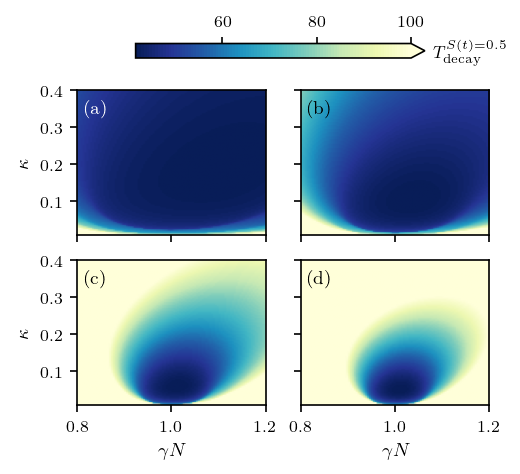

In [372]:
# --- Data & common settings ---
# kappa_vals: shape (Ny,), gamma_vals: shape (Nx,), N: scalar
# T_decay0p5_theory_single1..4: each shape (Ny, Nx)

extent = [gamma_vals[0]*N, gamma_vals[-1]*N, kappa_vals[0], kappa_vals[-1]]
cmap = plt.get_cmap('YlGnBu_r', 100)
vmax = 100  # keep consistent scaling across panels (set vmin if desired)

fig, axes = plt.subplots(2, 2, figsize=(3.40457,0.9*3.40457), constrained_layout=True, sharex=True, sharey=True)
ax11, ax12 = axes[0, 0], axes[0, 1]
ax21, ax22 = axes[1, 0], axes[1, 1]

# --- Panel (a) ---
im1 = ax11.imshow(T_decay0p5_theory_single1.T, origin='lower', aspect='auto',
                  extent=extent, cmap=cmap, vmax=vmax)
ax11.set_ylabel(r"$\kappa$")
ax11.set_title("(a)", x = 0.1, y = 0.75, color ='white')

# --- Panel (b) ---
im2 = ax12.imshow(T_decay0p5_theory_single2.T, origin='lower', aspect='auto',
                  extent=extent, cmap=cmap, vmax=vmax)
ax12.set_title("(b)", x = 0.1, y = 0.75)
# ax12.set_xlabel(r"$\gamma N$")  # usually omit on top row

# --- Panel (c) ---
im3 = ax21.imshow(T_decay0p5_theory_single3.T, origin='lower', aspect='auto',
                  extent=extent, cmap=cmap, vmax=vmax)
ax21.set_ylabel(r"$\kappa$")
ax21.set_title("(c)",x = 0.1, y = 0.75)
ax21.set_xlabel(r"$\gamma N$")

# --- Panel (d) ---
im4 = ax22.imshow(T_decay0p5_theory_single4.T, origin='lower', aspect='auto',
                  extent=extent, cmap=cmap, vmax=vmax)
ax22.set_title("(d)",x = 0.1, y = 0.75)
ax22.set_xlabel(r"$\gamma N$")

# --- Shared horizontal colorbar at top ---
cbar = fig.colorbar(im4, ax=[ax11, ax12, ax21, ax22], extend = 'max', location="top", pad=0.06, fraction=0.046)
# Put the colorbar title on the right edge of the bar

cbar.ax.text(1.08, -0.5, r"$T_{\rm decay}^{S(t)=0.5}$",
             transform=cbar.ax.transAxes, ha="left", va="bottom",fontsize = 8)

plt.savefig('supplementary_figure1.pdf',bbox_inches = 'tight',transparent = 'True', dpi = 600)
plt.show()

## Fix N, $\kappa = \kappa_{opt}$ compute the $t_{decay}$ to 0.001 (sensitivity of the optimal parameters)

In [394]:
# Parameters
Tcutoff = 12000
dt = 0.05
N = 2000  # System size'
kappa = kappa_opts_plot[2]
gamma_vals = np.linspace(0.9/N, 1.1/N, 100)

# Storage Arrays
T_decay0p001N3 = np.zeros(len(gamma_vals))
s_prob_arr = np.zeros((len(gamma_vals), int(Tcutoff / dt)))

# Compute Survival Probabilities and Transition Points
for gg, gamma in tqdm(enumerate(gamma_vals), total=len(gamma_vals)):
   # for kk, kappa in enumerate(kappa_vals):      
    s_prob = surv_prob_theory_total(Tcutoff, dt, N, gamma, kappa)
    s_prob_arr[gg] = s_prob
    T_decay0p001N3[gg] = find_transition_point(s_prob, dt,0.001)
            
#filename = f"survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}.pkl"
#dict_to_save = [gamma_vals, kappa_vals, r_vals, s_prob_arr, T_decay0p5]

#with open(filename, 'wb') as f:
#    pickle.dump(dict_to_save, f)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_3341753/733383813.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  s_prob[j] = first_term + second_term +third_term
100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


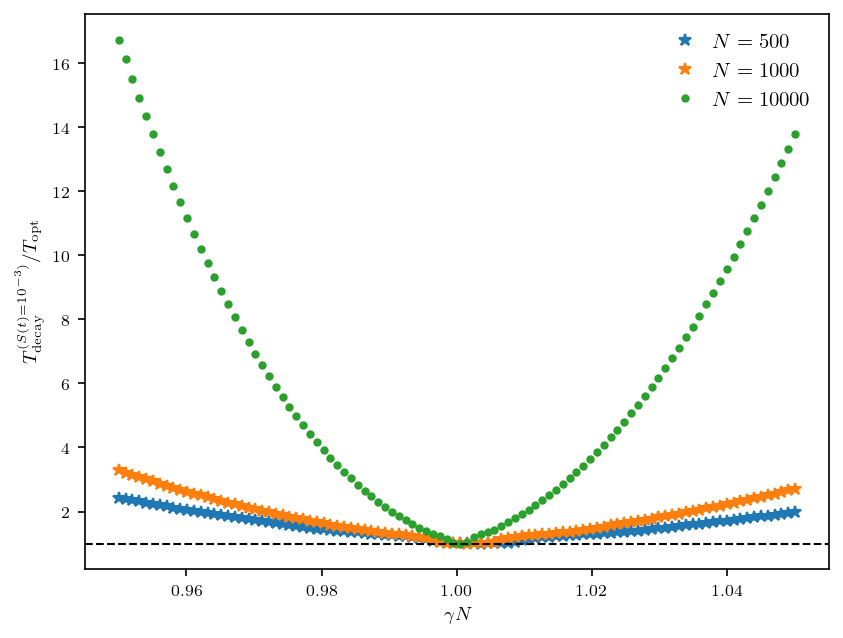

In [396]:
gamma_vals1 = np.linspace(0.95/2000, 1.05/2000, 100)


gamma_vals2 = np.linspace(0.95/1000, 1.05/1000, 100)


gamma_vals3 = np.linspace(0.95/500, 1.05/500, 100)

plt.plot(gamma_vals3*500, T_decay0p001N3/np.min(T_decay0p001N3[T_decay0p001N2>0]),'.',label = f'$N =500 $')
plt.plot(gamma_vals2*1000, T_decay0p001N2/np.min(T_decay0p001N2[T_decay0p001N2>0]),'*',label = f'$N =1000 $')
plt.plot(gamma_vals1*2000, T_decay0p001N1/np.min(T_decay0p001N1[T_decay0p001N1>0]),'^',label = f'$N =2000 $')



plt.axhline(1, ls = '--',color = 'k')
plt.xlabel(r'$\gamma N$')
plt.ylabel(r'$T_{\mathrm{decay}}^{(S(t) = 10^{-3})}/T_{\mathrm{opt}}$')

plt.legend(frameon = False)

#plt.savefig(r'prefactor_gammaN_no_resetting.pdf',bbox_inches = 'tight', dpi = 800)

plt.show()

## Fix N, $\gamma = \gamma_{opt}$ compute the $t_{decay}$ to 0.001 (sensitivity of the optimal parameters)

In [410]:
# Parameters
Tcutoff = 10000
dt = 0.05
kappa_vals = np.linspace(0.01, 0.1, 100)
N = 10000  # System size
gamma = 1/N

# Storage Arrays
T_decay0p001N1_k = np.zeros(len(kappa_vals))
s_prob_arr = np.zeros((len(kappa_vals), int(Tcutoff / dt)))

# Compute Survival Probabilities and Transition Points
for gg, kappa in tqdm(enumerate(kappa_vals), total=len(kappa_vals)):
   # for kk, kappa in enumerate(kappa_vals):      
    s_prob = surv_prob_theory_total(Tcutoff, dt, N, gamma, kappa)
    s_prob_arr[gg] = s_prob
    T_decay0p001N1_k[gg] = find_transition_point(s_prob, dt,0.001)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_3341753/733383813.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  s_prob[j] = first_term + second_term +third_term
100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


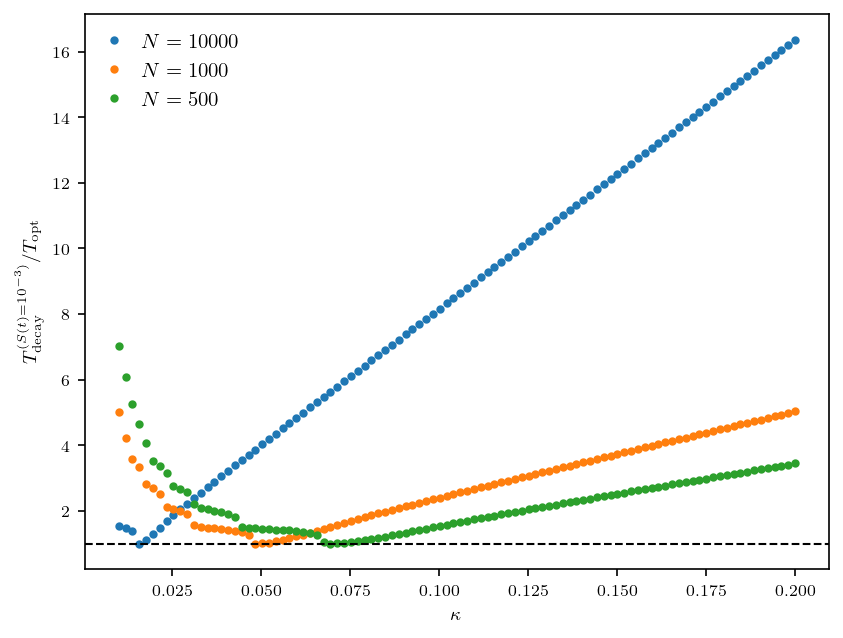

In [411]:
plt.plot(kappa_vals, T_decay0p001N1_k/np.min(T_decay0p001N1_k),'.',label = f'$N =10000 $')
plt.plot(kappa_vals, T_decay0p001N2_k/np.min(T_decay0p001N2_k),'.',label = f'$N =1000$')
plt.plot(kappa_vals, T_decay0p001N3_k/np.min(T_decay0p001N3_k),'.',label = f'$N =500$')


plt.axhline(1, ls = '--',color = 'k')
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$T_{\mathrm{decay}}^{(S(t) = 10^{-3})}/T_{\mathrm{opt}}$')

plt.legend(frameon = False)

#plt.savefig(r'prefactor_kappa_no_resetting.pdf',bbox_inches = 'tight', dpi = 800)

plt.show()

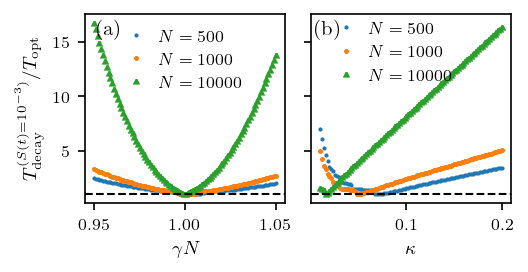

In [433]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(3.40457,0.5*3.40457), constrained_layout=True, sharey=True
)

# --- (a) gammaN scan ---
ax1.plot(gamma_vals3*500, T_decay0p001N3/np.min(T_decay0p001N3),'.',markersize =2,label = f'$N =500 $')
ax1.plot(gamma_vals2*1000, T_decay0p001N2/np.min(T_decay0p001N2[T_decay0p001N2>0]),'*',markersize =2,label = f'$N =1000 $')
ax1.plot(gamma_vals1*10000, T_decay0p001N1/np.min(T_decay0p001N1[T_decay0p001N1>0]),'^',markersize =2,label = f'$N =10000 $')

ax1.axhline(1, ls='--', color='k')
ax1.set_xlabel(r'$\gamma N$')
ax1.set_ylabel(r'$T_{\mathrm{decay}}^{(S(t)=10^{-3})}/T_{\mathrm{opt}}$')
ax1.legend(frameon=False, loc='best',fontsize = 8)
ax1.text(0.06, 0.98, '(a)', transform=ax1.transAxes, ha='left', va='top')

# --- (b) kappa scan ---
ax2.plot(kappa_vals, T_decay0p001N3_k/np.min(T_decay0p001N3_k),'.',markersize =2,label = f'$N =500$')
ax2.plot(kappa_vals, T_decay0p001N2_k/np.min(T_decay0p001N2_k),'*',markersize =2,label = f'$N =1000$')
ax2.plot(kappa_vals, T_decay0p001N1_k/np.min(T_decay0p001N1_k),'^',markersize =2,label = f'$N =10000 $')


ax2.axhline(1, ls='--', color='k')
ax2.set_xlabel(r'$\kappa$')
# y-label shared via sharey=True; omit here to save space
ax2.legend(frameon=False, loc= (0.1,0.6),fontsize = 8)
ax2.text(0.02, 0.98, '(b)', transform=ax2.transAxes, ha='left', va='top')
plt.savefig('supplementary_figure2.pdf', bbox_inches ='tight', transparent = "True", dpi = 600)
plt.show()

## Adaptive Grid size

In [378]:
# Parameters


NList =  np.floor(np.logspace(2,5,50)) # System size

for N in tqdm(NList):

    kappa_vals = np.linspace(1/np.sqrt(N), 3/np.sqrt(N), 100) # finer grid for $\kappa$

    Tcutoff = 20*np.sqrt(N) # cutoff time increasing with square root of N
    dt = 0.05

    gamma_vals = np.linspace(0.9/N, 1.1/N, 100)
    
    # Storage Arrays
    T_decay0p5_theory = np.zeros((len(gamma_vals), len(kappa_vals)))
    s_prob_arr_theory = np.zeros((len(gamma_vals), len(kappa_vals), int(Tcutoff / dt)))
    
    # Compute Survival Probabilities and Transition Points
    for gg, gamma in tqdm(enumerate(gamma_vals), total=len(gamma_vals)):
        for kk, kappa in enumerate(kappa_vals):
            s_prob_theory = surv_prob_theory_total(Tcutoff, dt, N, gamma, kappa)
            s_prob_arr_theory[gg, kk] = s_prob_theory
            T_decay0p5_theory[gg, kk] = find_transition_point(s_prob_theory, dt, 0.001)
    
    filename = f"../Data/Data_Log/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_theory_adaptive_grid_threshold_0p001_.pkl"
    dict_to_save = [gamma_vals, kappa_vals,T_decay0p5_theory]
    with open(filename, 'wb') as f:
        pickle.dump(dict_to_save, f)

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_1236670/733383813.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  s_prob[j] = first_term + second_term +third_term
100%|██████████| 50/50 [16:40:24<00:00, 1200.48s/it]


## Visualizations

In [46]:
# Parameters
NList =  np.floor(np.logspace(2,5,50))# System size


runtimes = np.zeros(len(NList))
gammaN_opts = np.zeros(len(NList))
kappa_opts = np.zeros(len(NList))

for j, N in enumerate(NList):

    Tcutoff = 20*np.sqrt(N)
    dt = 0.05

    filename = f"../Data/Data_Log/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_theory_adaptive_grid_threshold_0p001_.pkl"
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    gamma_vals, kappa_vals, T_decay0p5_theory = data

   
    T_decay0p5_theory = np.where(T_decay0p5_theory==0, np.inf, T_decay0p5_theory)

    #for gg in tqdm(range(len(gamma_vals))):
    #    for kk in range(len(kappa_vals)):
    #        T_decay_temp = T_decay0p5_theory[gg, kk]
    #        if len(T_decay_temp) > 0:
    #            T_min_theory[gg, kk] = np.min(T_decay_temp)
                #r_optimal[gg, kk] = r_vals[np.argmin(T_decay_temp)]
    #        else:
    #            T_min_theory[gg, kk] = np.nan  # Mark undefined cases
                #r_optimal[gg, kk] = np.nan

    id = np.unravel_index(T_decay0p5_theory.argmin(), T_decay0p5_theory.shape)
    runtimes[j] = T_decay0p5_theory[id[0]][id[1]]
    gammaN_opts[j] = gamma_vals[id[0]]
    kappa_opts[j] = kappa_vals[id[1]]

In [47]:
def timeScaling(Nlist):
    return [3.5*np.sqrt(N) for N in Nlist]

data = timeScaling(NList)

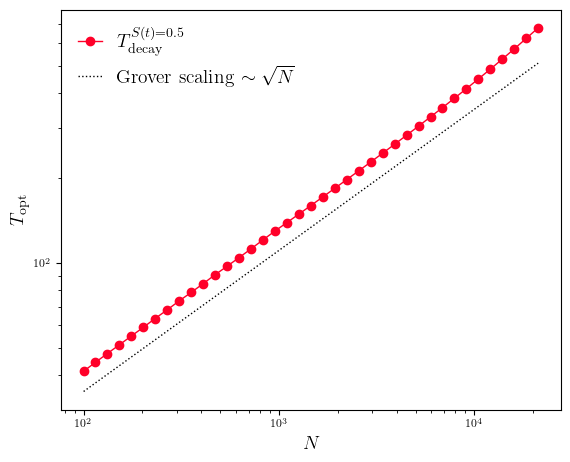

In [48]:
fig = plt.figure(figsize=(5,4)) #Generate figure with a given size
ax = fig.add_axes([0, 0, 1, 1]) #Add axes object to our figure that takes up entire figure

colors = plt.get_cmap('gist_rainbow', 16)
plt.plot(NList[:-11], runtimes[:-11], color=colors(0), marker='o', linestyle='-', label=r"$T_{\mathrm{decay}}^{S(t) = 0.5}$")
plt.plot(NList[:-11], np.array(data)[:-11], color="k", ls=":", label=r"Grover scaling $\sim \sqrt{N}$")
plt.xlabel(r"$N$",size = 14) #x-axis label
plt.ylabel(r"$T_{\mathrm{opt}}$", size = 14) #y-axis label
plt.legend(fontsize = 14)
#plt.legend(loc= 0, prop={'size': 12}, labelspacing=0.01, frameon=False)
plt.yscale('log')
plt.xscale('log')
#filename = f"Overlaps_figure_N{N}_dim{d}_alpha{alpha_str}.pdf"

#plt.tight_layout()
#plt.savefig("../Figures/Final/CompleteGraphTopt.pdf", dpi=800, transparent=True, bbox_inches='tight')

#plt.savefig('scaling.pdf',bbox_inches = 'tight')
plt.show()

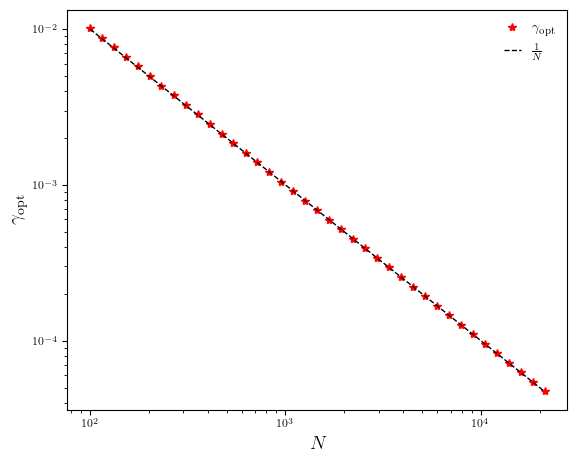

In [49]:
fig = plt.figure(figsize=(5,4))  # Same size as the first plot
ax1 = fig.add_axes([0, 0, 1, 1])  # Primary axis

# Energy curves on the primary y-axis
ax1.plot(NList[:-11], gammaN_opts[:-11],'*', label=r"$\gamma_{\rm opt}$", color="red")

# Primary axis settings
ax1.set_xlabel(r"$N$", size =14)
#plt.title(r"Optimal parameter values", color="black")
ax1.set_ylabel(r"$\gamma_{\rm opt}$", color="k", size = 14)
#ax1.tick_params(axis="both", direction="in", labelcolor="black")
#ax1.spines["left"].set_color("red")
#ax1.spines["left"].set_linewidth(1.5)
ax1.plot(NList[:-11],1/NList[:-11],'--', label=r"$~\frac{1}{N}$", color="k")

ax1.set_xscale('log')
ax1.set_yscale('log')

# Add a secondary y-axis for purity
#ax2 = ax1.twinx()
#ax2.plot(NList, kappa_opts,'o', label=r"$\kappa_{\rm opt}$", color="blue")
#ax2.set_ylabel(r"$\kappa_{\rm opt}$", color="blue", size = 14)
#ax2.tick_params(axis="y", direction="in", labelcolor="blue")
#ax2.spines["right"].set_color("blue")
#ax2.spines["right"].set_linewidth(1.5)
#ax2.plot(NList,1.4/np.sqrt(NList),'--', label=r"$~\frac{1}{\sqrt{N}}$", color="blue")


#ax2.set_xscale('log')
#ax2.set_yscale('log')


# Combined legend
lns1, labels1 = ax1.get_legend_handles_labels()
#lns2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lns1 + lns2, labels1 + labels2, loc="upper right", prop={'size': 12}, labelspacing=0.01, frameon=False)

ax1.legend()

#plt.tight_layout()

#plt.savefig("gamma_kappa_opt.pdf", dpi=800, transparent=True, bbox_inches='tight')


plt.show()

In [346]:
NList

array([   100.,    115.,    132.,    152.,    175.,    202.,    232.,
          268.,    308.,    355.,    409.,    471.,    542.,    625.,
          719.,    828.,    954.,   1098.,   1264.,   1456.,   1676.,
         1930.,   2222.,   2559.,   2947.,   3393.,   3906.,   4498.,
         5179.,   5963.,   6866.,   7906.,   9102.,  10481.,  12067.,
        13894.,  15998.,  18420.,  21209.,  24420.,  28117.,  32374.,
        37275.,  42919.,  49417.,  56898.,  65512.,  75431.,  86851.,
       100000.])

In [349]:
N = NList[12]
Tcutoff = 2*np.sqrt(N)
dt = 0.05

filename = f"../Data/Data_Log/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_theory_adaptive_grid.pkl"
with open(filename, 'rb') as f:
    data = pickle.load(f)
gamma_vals, kappa_vals, T_decay0p5_theory_single = data

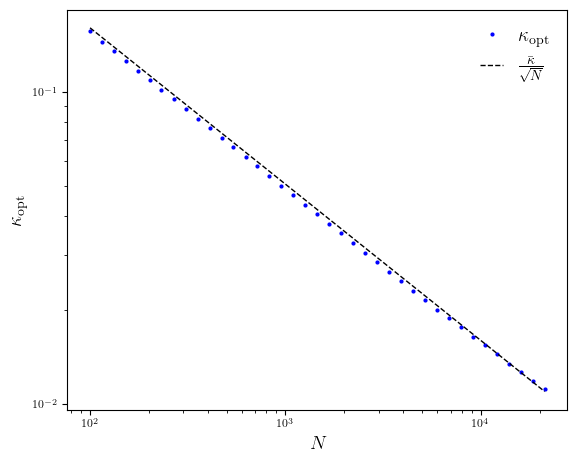

In [51]:
fig = plt.figure(figsize=(5,4))  # Same size as the first plot
ax1 = fig.add_axes([0, 0, 1, 1])  # Primary axis

# Energy curves on the primary y-axis
#ax1.plot(NList, gammaN_opts,'*', label=r"$\gamma_{\rm opt}$", color="red")

# Primary axis settings
#ax1.set_xlabel(r"$N$", size =14)
#plt.title(r"Optimal parameter values", color="black")
#ax1.set_ylabel(r"$\gamma_{\rm opt}$", color="k", size = 14)
#ax1.tick_params(axis="both", direction="in", labelcolor="black")
#ax1.spines["left"].set_color("red")
#ax1.spines["left"].set_linewidth(1.5)
#ax1.plot(NList,1/NList,'--', label=r"$~\frac{1}{N}$", color="k")

#ax1.set_xscale('log')
#ax1.set_yscale('log')

# Add a secondary y-axis for purity
#ax2 = ax1.twinx()
ax1.plot(NList[:-11], kappa_opts[:-11],'o', label=r"$\kappa_{\rm opt}$", color="blue",markersize = 2)
ax1.set_ylabel(r"$\kappa_{\rm opt}$", color="k", size = 14)
#ax1.tick_params(axis="y", direction="in", labelcolor="k")
#ax2.spines["right"].set_color("blue")
#ax2.spines["right"].set_linewidth(1.5)
ax1.plot(NList[:-11],1.6/np.sqrt(NList)[:-11],'--', label=r"$~\frac{\bar{\kappa}}{\sqrt{N}}$", color="k")
ax1.set_xlabel(r"$N$", size =14)

ax1.set_xscale('log')
ax1.set_yscale('log')


# Combined legend
lns1, labels1 = ax1.get_legend_handles_labels()
#lns2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lns1 + lns2, labels1 + labels2, loc="upper right", prop={'size': 12}, labelspacing=0.01, frameon=False)

ax1.legend(fontsize = 14)

#plt.tight_layout()

#plt.savefig("gamma_kappa_opt.pdf", dpi=800, transparent=True, bbox_inches='tight')


plt.show()

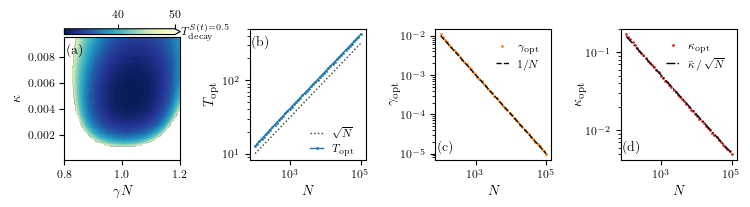

In [357]:
from matplotlib.ticker import LogLocator, NullFormatter

# ---------- Data need to be defined ----------
# T_decay0p5_theory_single : shape (len(kappa_vals), len(gamma_vals))
# kappa_vals, gamma_vals, N
# NList, runtimes, data
# gammaN_opts, kappa_opts

# axis for panel (a)
N = 500
gamma_vals = np.linspace(0.8/N, 1.2/N, 100)
gammaN_axis = gamma_vals * N

# ---------- Figure layout----------

fig = plt.figure(figsize=(8.67833,0.5*3.40457 ))
gs = fig.add_gridspec(1, 4, wspace=0.6) 

# ---------- (a) Heatmap: minimum search time ----------
ax_a = fig.add_subplot(gs[0, 0])
im = ax_a.imshow(
    T_decay0p5_theory_single.T, origin="lower", aspect="auto",
    extent=[gammaN_axis[0], gammaN_axis[-1], kappa_vals[0], kappa_vals[-1]],
    cmap=plt.get_cmap("YlGnBu_r", 50), vmax=50
)
ax_a.set_xlabel(r"$\gamma N$",fontsize = 10)
ax_a.set_ylabel(r"$\kappa$",fontsize = 10)
cbar = fig.colorbar(im, ax=ax_a, extend="max", pad=0.02, fraction=0.046,location = 'top')
cbar.ax.text(1.06, -1, r"$T_{\rm decay}^{S(t)=0.5}$",
             transform=cbar.ax.transAxes, ha="left", va="bottom", fontsize =8 )
#cbar.ax.set_title(r"$T_{\rm decay}^{S(t)=0.5}$",loc="right", pad=2)
ax_a.text(0.02,0.95 , "(a)", transform=ax_a.transAxes,va="top", ha="left",fontsize =10)

# ---------- (b) Scaling: T_opt vs N ----------
ax_b = fig.add_subplot(gs[0, 1])
ax_b.plot(NList, np.array(data), color="0.2", linestyle=":",
          label=r"$ \sqrt{N}$")
ax_b.plot(NList, runtimes, marker="o", linestyle="-", markersize = 1 ,lw = 1,
          label=r"$T_{\mathrm{opt}}$" )

ax_b.set_xscale("log")
ax_b.set_yscale("log")
ax_b.set_xlabel(r"$N$",fontsize = 10)
ax_b.set_ylabel(r"$T_{\mathrm{opt}}$",fontsize = 10)
ax_b.legend(frameon=False,loc= (0.48,0),fontsize = 8)
# nicer log ticks
ax_b.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2,10)*0.1))
ax_b.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2,10)*0.1))
ax_b.yaxis.set_minor_formatter(NullFormatter())
ax_b.text(0.02,0.95 , "(b)", transform=ax_b.transAxes,va="top", ha="left",fontsize =10)

# ---------- (c) gamma_opt vs N ----------
ax_c = fig.add_subplot(gs[0, 2])
ax_c.plot(NList, gammaN_opts, "o", markersize = 1, label=r"$\gamma_{\rm opt}$", color="C1")
ax_c.plot(NList, 1/np.array(NList), "--", color="k", label=r"$1/N$")
ax_c.set_xscale("log")
ax_c.set_yscale("log")
ax_c.set_xlabel(r"$N$",fontsize = 10)
ax_c.set_ylabel(r"$\gamma_{\rm opt}$",fontsize = 10,labelpad=1)
ax_c.legend(frameon=False, loc= (0.48,0.65),fontsize =8)
ax_c.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2,10)*0.1))
ax_c.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2,10)*0.1))
ax_c.yaxis.set_minor_formatter(NullFormatter())
ax_c.text(0.02,0.15, "(c)", transform=ax_c.transAxes,va="top", ha="left",fontsize =10)

# ---------- (d) kappa_opt vs N ----------
ax_d = fig.add_subplot(gs[0, 3])
ax_d.plot(NList, kappa_opts, "o",markersize = 1, label=r"$\kappa_{\rm opt}$", color="C3")
ax_d.plot(NList, 1.6/np.sqrt(np.array(NList)), "-.", color="k",
          label=r"$ \bar{\kappa}\, /\,\sqrt{N}$")
ax_d.set_xscale("log")
ax_d.set_yscale("log")
ax_d.set_xlabel(r"$N$",fontsize = 10)
ax_d.set_ylabel(r"$\kappa_{\rm opt}$",fontsize = 10,labelpad=0)
ax_d.legend(frameon=False, loc= (0.35,0.65), fontsize = 8 )
ax_d.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2,10)*0.1))
ax_d.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2,10)*0.1))
ax_d.yaxis.set_minor_formatter(NullFormatter())
ax_d.text(0.02,0.15 , "(d)", transform=ax_d.transAxes,va="top", ha="left",fontsize =10)

# ---------- Tight layout & save ----------
#fig.tight_layout()
#plt.savefig("Figure1.pdf", bbox_inches="tight", transparent=True)
plt.show()


## Checking the theoretical approximation

In [441]:
def surv_prob_approximation(Tcutoff,dt,N):

    m = int(Tcutoff / dt)  # Number of time steps, each with duration dt

    s_prob = np.zeros(m) # Initialize array

    for j in range(m): 
        first_term = np.exp(-j*dt/np.sqrt(N))*(2/3 - 2/(3*np.sqrt(3*N)) + 4/(27*N))
        second_term =  np.exp(-j*dt/np.sqrt(N))*(2/3 + 2/(3*np.sqrt(3*N)) + 4/(9*N))
        third_term = 2*np.exp(-j*dt/np.sqrt(N))*np.cos(np.sqrt(3/N)*j*dt)*(1/3- 11/(54*N))
        fourth_term = 2*np.exp(-j*dt/np.sqrt(N))*np.sin(np.sqrt(3/N)*j*dt)*(2/((9*np.sqrt(N))) +  5/(18*np.sqrt(3)*N))

        s_prob[j]= first_term + second_term + third_term - fourth_term 

    return s_prob

In [442]:
def surv_prob_theory_total(Tcutoff, dt, N, gamma, kappa):

    """
    Compute the survival probability as a function of time analytically in two-dimensional basis without any reset.
    
    Args:
        Tcutoff (float): Cutoff time for the dynamics.
        dt (float): Discretization of time into time steps of duration dt.
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.
        
    Returns:
        np.ndarray: Survival probabilities.
    """
 
    m = int(Tcutoff / dt)  # Number of time steps, each with duration dt

    #eigenvalues
    lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

    #overlaps 
    overlap_plus, overlap_minus,overlap_pm = overlap(N,gamma,kappa)
   
    s_prob = np.zeros(m) # Initialize array

    for j in range(m): 
        first_term  = np.exp(-1.0j*(lambda_plus - np.conj(lambda_plus))*j*dt)*overlap_plus
        second_term = np.exp(-1.0j*(lambda_minus - np.conj(lambda_minus))*j*dt)*overlap_minus
        third_term  = 2*np.real(np.exp(-1.0j*(lambda_minus - np.conj(lambda_plus))*j*dt)*overlap_pm)

        s_prob[j] = first_term + second_term +third_term


    return s_prob

In [503]:
T_cutoff = 10000
dt = 0.05
N = 1000000
gamma = 1/N
kappa= 1/np.sqrt(N)


s_prob_actual = surv_prob_theory_total(T_cutoff, dt, N, gamma, kappa)
#s_prob_approx = surv_prob_approximation(T_cutoff,dt,N)

/tmp/ipykernel_3341753/733383813.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  s_prob[j] = first_term + second_term +third_term


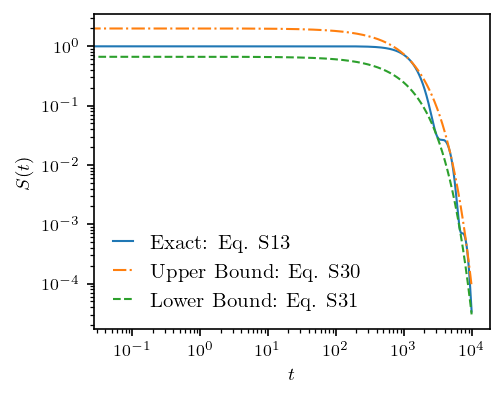

In [510]:
plt.figure(figsize=(3.40457,0.8*3.40457))
time_array = np.arange(0,T_cutoff,dt)
plt.plot(time_array, s_prob_actual, label = r'Exact: Eq. S13')
#plt.plot(time_array, s_prob_approx,'--', label = r'Approx1')
plt.plot(time_array,2*np.exp(-time_array/np.sqrt(N)),'-.', label = r'Upper Bound: Eq. S30')
plt.plot(time_array,(2/3)*np.exp(-time_array/np.sqrt(N)),'--', label = r'Lower Bound: Eq. S31')

plt.xscale('log')
plt.yscale('log')


plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$S(t)$')

plt.savefig('../Figure_paper/supplementary_figure3.pdf',bbox_inches='tight', transparent = 'True', dpi = 600)
plt.show()

## Deterministic Resetting is beneficial or not

In [58]:
def overlap_reset(N,gamma,kappa,ket_s):

    """
    Compute the analytical expresion of the overlaps with initial uniform superposition state. The overlaps corresponds to each term
    in the analytical expression of survival probability (see text for more details). 

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.
        ket_s (np.ndarray): the reset state

    Returns:
        overlap_plus (float): Overlap correspond to the decay rate governed by Im[lambda_plus].
        overlap_minus (float): Overlap correspond to the decay rate governed by Im[lambda_minus].
        overlap_pm (complex): Overlap correspond to the term having cross terms from both eigenvalues.
    """  

    lambdaR_plus, lambdaR_minus = lambdaR(N,gamma,kappa)
    lambdaL_plus, lambdaL_minus = lambdaL(N,gamma,kappa)

    overlap_plus =(1/np.abs(np.vdot(lambdaL_plus,lambdaR_plus))**2)*np.vdot(lambdaR_plus,lambdaR_plus)*np.abs(np.vdot(ket_s, lambdaL_plus))**2

    overlap_minus =(1/np.abs(np.vdot(lambdaL_minus,lambdaR_minus))**2)*np.vdot(lambdaR_minus,lambdaR_minus)*np.abs(np.vdot(ket_s, lambdaL_minus))**2

    #overlap_pm = (1/(np.vdot(lambdaR_plus,lambdaL_plus)*np.vdot(lambdaL_minus,lambdaR_minus)))*np.vdot(ket_s,lambdaL_plus)*np.vdot(lambdaL_minus,ket_s)*np.vdot(lambdaR_plus, lambdaR_minus)
    #overlap_mp = (1/(np.vdot(lambdaR_minus,lambdaL_minus)*np.vdot(lambdaL_plus,lambdaR_plus)))*np.vdot(ket_s,lambdaL_minus)*np.vdot(lambdaL_plus,ket_s)*np.vdot(lambdaR_minus, lambdaR_plus)
    overlap_pm = (1/(np.vdot(lambdaR_plus,lambdaL_plus)*np.vdot(lambdaL_minus,lambdaR_minus)))*np.vdot(ket_s,lambdaL_plus)*np.vdot(lambdaL_minus,ket_s)*np.vdot(lambdaR_plus, lambdaR_minus)

    return overlap_plus, overlap_minus,overlap_pm


def surv_prob_det_reset(Tcutoff, dt, r, N, gamma, kappa):
    
    """
    Compute the survival probability as a function of time using analytics in two dimensional basis. Here reset is done using
    deterministic protocol to the initial state.
    
    Args:
        Tcutoff (float): Cutoff time for the dynamics.
        dt (float): Discretization of time into time steps of duration dt.
        r (int): reset value (such that the time after which we reset is t_reset = r*dt).
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        w (int): Target node/site location; dynamics invariant under choice of w.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.
        
    Returns:
        np.ndarray: Survival probabilities.
    """
  
    m = int(Tcutoff / dt)
    s_prob_reset = np.zeros(m)

    # Initial state
    initial_state =np.array([1.0/np.sqrt(N), np.sqrt((N-1)/N)])
    reset_state = initial_state.copy()

    # Set initial survival probability
    s_prob_reset[0] = 1
    #has_crossed_half_decay = False

    # Precompute eigenvalues and deltas
    lambda_plus, lambda_minus = lambda_pm(N, gamma, kappa)
    overlap_plus, overlap_minus, overlap_pm = overlap_reset(N, gamma, kappa, reset_state)

    t_r = 0

    for j in range(1, m):

        first_term  = np.exp(-1.0j*(lambda_plus - np.conj(lambda_plus))*(j*dt -t_r))*overlap_plus
        second_term = np.exp(-1.0j*(lambda_minus - np.conj(lambda_minus))*(j*dt -t_r))*overlap_minus
        third_term  = 2*np.real(np.exp(-1.0j*(lambda_minus - np.conj(lambda_plus))*(j*dt -t_r))*overlap_pm)

        s_prob_reset[j] = np.real(first_term + second_term + third_term)

        # If survival probability crossed below 0.5, activate reset logic
        #if not has_crossed_half_decay and s_prob_reset[j-1] < 0.5:
            #has_crossed_half_decay = True

        #if has_crossed_half_decay and r != 0 and j % r == 0:
        if r != 0 and j % r == 0:
            t_r =  j*dt
            reset_state = np.sqrt(s_prob_reset[j])* np.array([1.0/np.sqrt(N), np.sqrt((N-1)/N)])
            overlap_plus, overlap_minus, overlap_pm = overlap_reset(N, gamma, kappa, reset_state)
            #print(overlap_plus + overlap_minus + 2*np.real(overlap_pm), s_prob_reset[j])

    return s_prob_reset

### Individual trajectories

In [92]:
N = 10000
gamma = 1.0/N
kappa = 10/np.sqrt(N)
dt = 0.001
Tcutoff = 10*np.sqrt(N)


s_prob_reset = surv_prob_det_reset(Tcutoff, dt, 0, N, gamma, kappa)
s_prob_reset1= surv_prob_det_reset(Tcutoff, dt, 1, N, gamma, kappa)

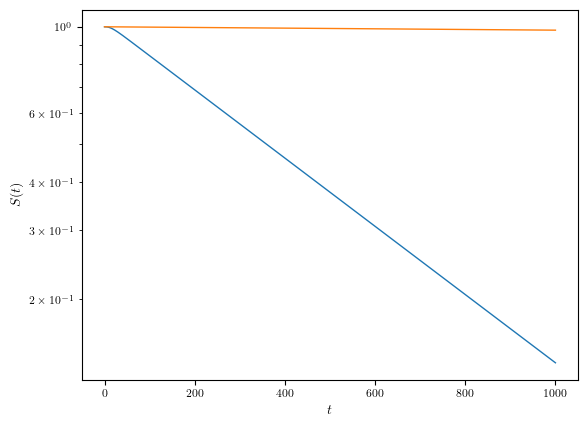

In [93]:
T = np.arange(0,Tcutoff,dt)

plt.plot(T, s_prob_reset)
plt.plot(T, s_prob_reset1)


plt.ylabel(r'$S(t)$')
plt.xlabel(r'$t$')

plt.yscale('log')
plt.show()

In [88]:
overlap(N,gamma,kappa)

(np.complex128(1.031033835490703+0j),
 np.complex128(0.01062812926962118+0j),
 np.complex128(-0.020830982380153098-0.0020835365085963655j))

In [89]:
lambda_pm(N,gamma,kappa)

(np.complex128(-0.9998979381488713-0.0010100988302546854j),
 np.complex128(-1.0001020618511287-0.09898990116974532j))

### Find $\kappa_{opt}$ and $\gamma_{opt}$ for $N= 500,1000,2000$

In [553]:
kappa_vals = np.linspace(0, 0.4, 100)
Nplot =  [542,1098,2222] # System size


for N in tqdm(Nplot):

    Tcutoff = 2*np.sqrt(N) # cutoff time increasing with square root of N
    dt = 0.05


    gamma_vals = np.linspace(0.9/N, 1.1/N, 100)
    
    # Storage Arrays
    T_decay0p5_theory = np.zeros((len(gamma_vals), len(kappa_vals)))
    s_prob_arr_theory = np.zeros((len(gamma_vals), len(kappa_vals), int(Tcutoff / dt)))
    
    # Compute Survival Probabilities and Transition Points
    for gg, gamma in tqdm(enumerate(gamma_vals), total=len(gamma_vals)):
        for kk, kappa in enumerate(kappa_vals):
            s_prob_theory = surv_prob_theory_total(Tcutoff, dt, N, gamma, kappa)
            s_prob_arr_theory[gg, kk] = s_prob_theory
            T_decay0p5_theory[gg, kk] = find_transition_point(s_prob_theory, dt, 0.5)

    filename = f"../Data/Data_Log/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_theory_final.pkl"
    dict_to_save = [gamma_vals, kappa_vals, T_decay0p5_theory]
    with open(filename, 'wb') as f:
        pickle.dump(dict_to_save, f)

  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_3341753/733383813.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  s_prob[j] = first_term + second_term +third_term
100%|██████████| 3/3 [02:23<00:00, 47.78s/it]


In [564]:
# Parameters
Nplot =  [500,1000,2000] # System size


runtimes_plot = np.zeros(len(Nplot))
gammaN_opts_plot = np.zeros(len(Nplot))
kappa_opts_plot = np.zeros(len(Nplot))

for j, N in enumerate(Nplot):

    Tcutoff = 2*np.sqrt(N)
    dt = 0.05

    filename = f"../Data/Data_Log/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_theory_final.pkl"
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    gamma_vals, kappa_vals,T_decay0p5_theory = data
    
    T_decay0p5_theory = np.where(T_decay0p5_theory==0, np.inf, T_decay0p5_theory)

    id = np.unravel_index(T_decay0p5_theory.argmin(), T_decay0p5_theory.shape)
    runtimes_plot[j] = T_decay0p5_theory[np.unravel_index(T_decay0p5_theory.argmin(), T_decay0p5_theory.shape)]
    gammaN_opts_plot[j] = gamma_vals[id[0]]
    kappa_opts_plot[j] = kappa_vals[id[1]]

## Fix N = [500,1000,2000], $\kappa = \kappa_{opt}$, find the optimum reset rate and the corresponding $t^r_{decay}$

In [596]:
# Parameters
index = 2
N = Nplot[index] # System size
kappa = kappa_opts_plot[index]



Tcutoff = 3600 # cutoff time increasing with square root of N
dt = 0.05

r_vals = np.linspace(0, (Tcutoff+1)/10/dt, 50, dtype=int)

gamma_vals = np.linspace(0.9/N, 1.1/N, 50)

# Storage Arrays
T_decay_reset3_g = np.zeros((len(gamma_vals), len(r_vals)))
s_prob_det_reset = np.zeros((len(gamma_vals), len(r_vals), int(Tcutoff / dt)))

# Compute Survival Probabilities and transition
for gg, gamma in tqdm(enumerate(gamma_vals), total=len(gamma_vals)):
    #for kk, kappa in enumerate(kappa_vals):
    for rr, r in tqdm(enumerate(r_vals)):
        s_prob_theory = surv_prob_det_reset(Tcutoff, dt, r, N, gamma, kappa)
        s_prob_det_reset[gg, rr] = s_prob_theory
        T_decay_reset3_g[gg, rr] = find_transition_point(s_prob_theory, dt, 0.001)

filename = f"../Data/Data_Log/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_reset_plot.pkl"
dict_to_save = [gamma_vals, kappa_vals, r_vals, T_decay_reset3_g]
with open(filename, 'wb') as f:
    pickle.dump(dict_to_save, f)

50it [00:12,  4.10it/s]00:00<?, ?it/s]
50it [00:12,  4.10it/s]00:12<09:57, 12.19s/it]
50it [00:12,  4.10it/s]00:24<09:45, 12.20s/it]
50it [00:12,  4.13it/s]00:36<09:33, 12.20s/it]
50it [00:12,  4.13it/s]00:48<09:19, 12.16s/it]
50it [00:12,  4.11it/s]01:00<09:06, 12.14s/it]
50it [00:12,  4.11it/s]01:12<08:54, 12.15s/it]
50it [00:11,  4.25it/s]01:25<08:42, 12.16s/it]
50it [00:11,  4.17it/s]01:36<08:25, 12.03s/it]
50it [00:12,  4.11it/s]01:48<08:12, 12.02s/it]
50it [00:12,  4.10it/s][02:01<08:02, 12.06s/it]
50it [00:12,  4.10it/s][02:13<07:51, 12.10s/it]
50it [00:12,  4.12it/s][02:25<07:40, 12.13s/it]
50it [00:12,  4.13it/s][02:37<07:28, 12.13s/it]
50it [00:12,  4.10it/s][02:49<07:16, 12.12s/it]
50it [00:12,  4.09it/s][03:01<07:04, 12.14s/it]
50it [00:12,  4.11it/s][03:14<06:53, 12.16s/it]
50it [00:12,  4.12it/s][03:26<06:41, 12.16s/it]
50it [00:12,  4.11it/s][03:38<06:28, 12.15s/it]
50it [00:12,  4.11it/s][03:50<06:16, 12.16s/it]
50it [00:12,  4.10it/s][04:02<06:04, 12.16s/it]
50it [00:1

In [277]:
N = 500
Tcutoff = 3600 
dt = 0.05

filename = f"../Data/Data_Log/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_reset_plot.pkl"

with open(filename, 'rb') as f:
    dict_to_read = pickle.load(f)

In [278]:
gamma_vals, kappa_vals, r_vals, T_decay_reset1_g = dict_to_read

In [279]:
r_opt1_g = np.zeros(len(gamma_vals))
Tr_optN1_g = np.zeros(len(gamma_vals))
Tr_no_resetN1_g = np.zeros(len(gamma_vals))

for i in range(len(gamma_vals)):
    diffs = T_decay_reset1_g[i] - T_decay_reset1_g[i][0]
    min_j = np.argmin(diffs)
    if diffs[min_j] < diffs[0]:
        j = min_j
    else:
        j = 0
    r_opt1_g[i] = r_vals[j]
    Tr_optN1_g[i] = T_decay_reset1_g[i][j]
    Tr_no_resetN1_g[i] = T_decay_reset1_g[i][0]

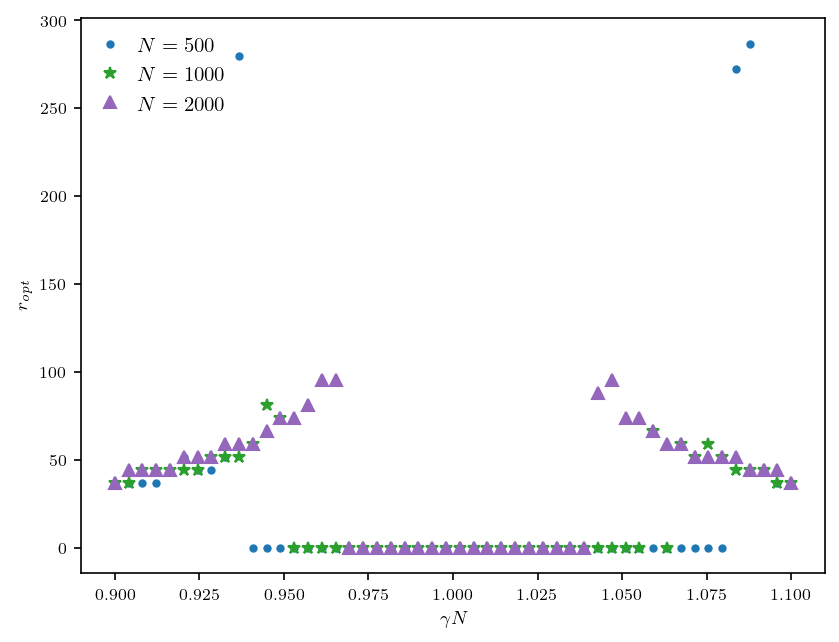

In [608]:
gamma_vals1 = np.linspace(0.9/Nplot[0], 1.1/Nplot[0], 50)
gamma_vals2 = np.linspace(0.9/Nplot[1], 1.1/Nplot[1], 50)
gamma_vals3 = np.linspace(0.9/Nplot[2], 1.1/Nplot[2], 50)


plt.plot(gamma_vals1*Nplot[0], r_opt1_g*dt,'.',color = 'C0', label = f'$N = {int(Nplot[0])}$')

plt.plot(gamma_vals2*Nplot[1], r_opt2_g*dt,'*',color = 'C2', label = f'$N = {int(Nplot[1])}$')

plt.plot(gamma_vals3*Nplot[2], r_opt3_g*dt,'^',color = 'C4', label = f'$N = {int(Nplot[2])}$')


plt.legend()
plt.xlabel(r'$\gamma N$')
plt.ylabel(r'$r_{opt}$')

plt.show()

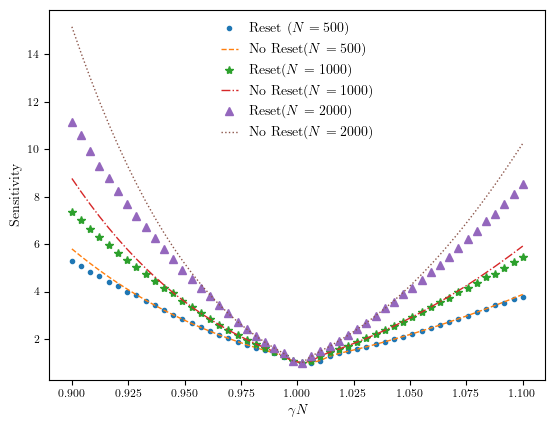

In [280]:

Nplot = [500,1000,2000]

# ---------- (b) r_opt vs γN ----------
gamma_vals1 = np.linspace(0.9 / Nplot[0], 1.1 / Nplot[0], 50)
gamma_vals2 = np.linspace(0.9 / Nplot[1], 1.1 / Nplot[1], 50)
gamma_vals3 = np.linspace(0.9 / Nplot[2], 1.1 / Nplot[2], 50)


plt.plot(gamma_vals1*Nplot[0], Tr_optN1_g/np.min(Tr_optN1_g),'.',label = f'Reset $(N = {int(Nplot[0])})$')
plt.plot(gamma_vals1*Nplot[0], Tr_no_resetN1_g/np.min(Tr_no_resetN1_g),'--', label = f'No Reset$(N = {int(Nplot[0])})$')

plt.plot(gamma_vals2*Nplot[1], Tr_optN2_g/np.min(Tr_optN2_g),'*',label = f'Reset$(N = {int(Nplot[1])})$')
plt.plot(gamma_vals2*Nplot[1], Tr_no_resetN2_g/np.min(Tr_no_resetN2_g),'-.', label = f'No Reset$(N = {int(Nplot[1])})$')

plt.plot(gamma_vals3*Nplot[2], Tr_optN3_g/np.min(Tr_optN3_g),'^',label = f'Reset$(N = {int(Nplot[2])})$')
plt.plot(gamma_vals3*Nplot[2], Tr_no_resetN3_g/np.min(Tr_no_resetN3_g),':', label = f'No Reset$(N = {int(Nplot[2])})$')



plt.legend(frameon = False)

plt.xlabel(r'$\gamma N$')
plt.ylabel(r'Sensitivity')

#plt.savefig(r'det_reset_comparision_N123_gammaN.pdf',bbox_inches = 'tight', dpi = 600)
plt.show()

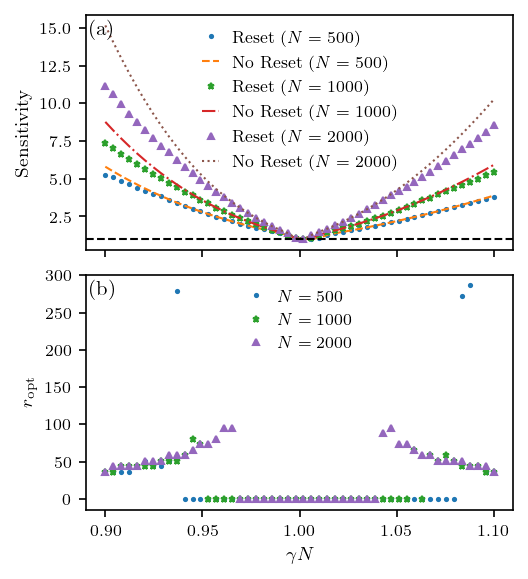

In [618]:

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, figsize=(3.40457,1.1*3.40457), sharex=True, constrained_layout=True
)

# ---------- (a) Sensitivity vs γN ----------
ax_top.plot(gamma_vals1 * Nplot[0], Tr_optN1_g / np.min(Tr_optN1_g), '.',markersize = 3,
            label=fr'Reset $(N = {int(Nplot[0])})$')
ax_top.plot(gamma_vals1 * Nplot[0], Tr_no_resetN1_g / np.min(Tr_no_resetN1_g), '--',
            label=fr'No Reset $(N = {int(Nplot[0])})$')

ax_top.plot(gamma_vals2 * Nplot[1], Tr_optN2_g / np.min(Tr_optN2_g), '*',markersize = 3,
            label=fr'Reset $(N = {int(Nplot[1])})$')
ax_top.plot(gamma_vals2 * Nplot[1], Tr_no_resetN2_g / np.min(Tr_no_resetN2_g), '-.',
            label=fr'No Reset $(N = {int(Nplot[1])})$')

ax_top.plot(gamma_vals3 * Nplot[2], Tr_optN3_g / np.min(Tr_optN3_g), '^',markersize = 3,
            label=fr'Reset $(N = {int(Nplot[2])})$')
ax_top.plot(gamma_vals3 * Nplot[2], Tr_no_resetN3_g / np.min(Tr_no_resetN3_g), ':',
            label=fr'No Reset $(N = {int(Nplot[2])})$')

ax_top.axhline(1, ls='--', color='k')
ax_top.set_ylabel(r'Sensitivity')
ax_top.legend(frameon=False, loc='best',fontsize = 8)
ax_top.text(0.01, 0.98, '(a)', transform=ax_top.transAxes, ha='left', va='top')

# ---------- (b) r_opt vs γN ----------
gamma_vals1 = np.linspace(0.9 / Nplot[0], 1.1 / Nplot[0], 50)
gamma_vals2 = np.linspace(0.9 / Nplot[1], 1.1 / Nplot[1], 50)
gamma_vals3 = np.linspace(0.9 / Nplot[2], 1.1 / Nplot[2], 50)

ax_bot.plot(gamma_vals1 * Nplot[0], r_opt1_g * dt, '.', color='C0',markersize = 3,
            label=fr'$N = {int(Nplot[0])}$')
ax_bot.plot(gamma_vals2 * Nplot[1], r_opt2_g * dt, '*', color='C2',markersize = 3,
            label=fr'$N = {int(Nplot[1])}$')
ax_bot.plot(gamma_vals3 * Nplot[2], r_opt3_g * dt, '^', color='C4',markersize = 3,
            label=fr'$N = {int(Nplot[2])}$')

ax_bot.set_xlabel(r'$\gamma N$')
ax_bot.set_ylabel(r'$r_{\mathrm{opt}}$')
ax_bot.legend(frameon=False, loc='best',fontsize = 8)
ax_bot.text(0.01, 0.98, '(b)', transform=ax_bot.transAxes, ha='left', va='top')

# Optional tuning:
# fig.subplots_adjust(hspace=0.15)  # extra vertical space if needed
# for ax in (ax_top, ax_bot): ax.tick_params(axis='y', pad=2)


#plt.savefig(r'Figure2.pdf',bbox_inches = 'tight',transparent = 'True', dpi = 600)
plt.show()

## Fix N = [500,1000,2000], $\gamma = \gamma_{opt}$, find the optimum reset rate and the corresponding $t^r_{decay}$

In [640]:
# Parameters
kappa_vals =  np.linspace(0, 0.2, 50)
N = Nplot[0] # System size

Tcutoff = 3600 # cutoff time increasing with square root of N
dt = 0.05

r_vals = np.linspace(0, (Tcutoff+1)/10/dt, 50, dtype=int)

gamma = gammaN_opts_plot[0]

# Storage Arrays
T_decay_reset3_k = np.zeros((len(kappa_vals), len(r_vals)))
s_prob_det_reset = np.zeros((len(kappa_vals), len(r_vals), int(Tcutoff / dt)))

# Compute Survival Probabilities and transition
for gg, kappa in tqdm(enumerate(kappa_vals), total=len(kappa_vals)):
    #for kk, kappa in enumerate(kappa_vals):
    for rr, r in tqdm(enumerate(r_vals)):
        s_prob_theory = surv_prob_det_reset(Tcutoff, dt, r, N, gamma, kappa)
        s_prob_det_reset[gg, rr] = s_prob_theory
        T_decay_reset3_k[gg, rr] = find_transition_point(s_prob_theory, dt, 0.001)

filename = f"../Data/Data_Log/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_reset_kappa.pkl"
dict_to_save = [gamma_vals, kappa_vals, r_vals, T_decay_reset3_k]
with open(filename, 'wb') as f:
    pickle.dump(dict_to_save, f)

50it [00:12,  4.10it/s]00:00<?, ?it/s]
50it [00:12,  4.12it/s]00:12<09:58, 12.20s/it]
50it [00:12,  4.12it/s]00:24<09:44, 12.17s/it]
50it [00:12,  4.12it/s]00:36<09:31, 12.16s/it]
50it [00:12,  4.11it/s]00:48<09:18, 12.15s/it]
50it [00:12,  4.10it/s]01:00<09:06, 12.16s/it]
50it [00:12,  4.12it/s]01:12<08:55, 12.17s/it]
50it [00:12,  4.12it/s]01:25<08:42, 12.15s/it]
50it [00:12,  4.12it/s]01:37<08:30, 12.14s/it]
50it [00:12,  4.11it/s]01:49<08:17, 12.14s/it]
50it [00:12,  4.11it/s][02:01<08:06, 12.16s/it]
50it [00:12,  4.11it/s][02:13<07:54, 12.16s/it]
50it [00:12,  4.12it/s][02:25<07:42, 12.16s/it]
50it [00:12,  4.11it/s][02:38<07:29, 12.16s/it]
50it [00:12,  4.10it/s][02:50<07:17, 12.16s/it]
50it [00:12,  4.09it/s][03:02<07:05, 12.17s/it]
50it [00:12,  4.06it/s][03:14<06:54, 12.19s/it]
50it [00:12,  4.07it/s][03:26<06:43, 12.22s/it]
50it [00:12,  4.05it/s][03:39<06:31, 12.24s/it]
50it [00:12,  4.05it/s][03:51<06:20, 12.27s/it]
50it [00:12,  4.06it/s][04:03<06:08, 12.29s/it]
50it [00:1

In [641]:
r_opt3_k = np.zeros(len(gamma_vals)-1)
Tr_optN3_k = np.zeros(len(gamma_vals)-1)
Tr_no_resetN3_k = np.zeros(len(gamma_vals)-1)

for i in range(1,len(gamma_vals)):
    diffs = T_decay_reset3_k[i] - T_decay_reset3_k[i][0]
    min_j = np.argmin(diffs)
    if diffs[min_j] < diffs[0]:
        j = min_j
    else:
        j = 0
    r_opt3_k[i-1] = r_vals[j]
    Tr_optN3_k[i-1] = T_decay_reset3_k[i][j]
    Tr_no_resetN3_k[i-1] = T_decay_reset3_k[i][0]

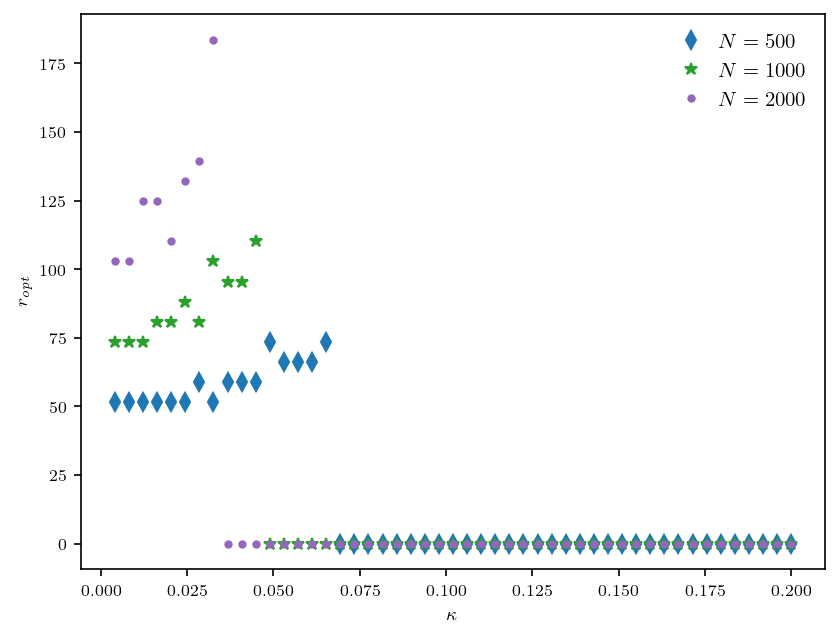

In [642]:
plt.plot(kappa_vals[1:], r_opt1_k*dt,'d',color = 'C0', label = f'$N = {int(Nplot[0])}$')
plt.plot(kappa_vals[1:], r_opt2_k*dt,'*',color = 'C2', label = f'$N = {int(Nplot[1])}$')
plt.plot(kappa_vals[1:], r_opt3_k*dt,'.',color = 'C4', label = f'$N = {int(Nplot[2])}$')


plt.legend()
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$r_{opt}$')

plt.show()

In [255]:
plt.plot(kappa_vals[1:], Tr_optN1_k/np.min(Tr_optN1_k),'.',label = f'Reset $(N = {int(Nplot[0])})$')
plt.plot(kappa_vals[1:], Tr_no_resetN1_k/np.min(Tr_no_resetN1_k),'--', label = f'No Reset$(N = {int(Nplot[0])})$')

plt.plot(kappa_vals[1:], Tr_optN2_k/np.min(Tr_optN2_k),'*',label = f'Reset$(N = {int(Nplot[1])})$')
plt.plot(kappa_vals[1:], Tr_no_resetN2_k/np.min(Tr_no_resetN2_k),'-.', label = f'No Reset$(N = {int(Nplot[1])})$')

plt.plot(kappa_vals[1:], Tr_optN3_k/np.min(Tr_optN3_k),'^',label = f'Reset$(N = {int(Nplot[2])})$')
plt.plot(kappa_vals[1:], Tr_no_resetN3_k/np.min(Tr_no_resetN3_k),':', label = f'No Reset$(N = {int(Nplot[2])})$')



plt.legend(frameon = False)

plt.xlabel(r'$\kappa$')
plt.ylabel(r'Sensitivity')
plt.axhline(1, ls='--', color='k')
#plt.savefig(r'det_reset_comparision_N123_gammaN.pdf',bbox_inches = 'tight', dpi = 600)
plt.show()

NameError: name 'Tr_optN1_k' is not defined

NameError: name 'Tr_optN1_k' is not defined

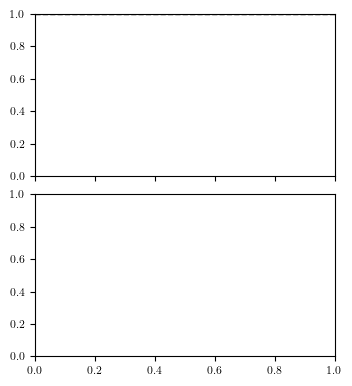

In [281]:

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, figsize=(3.40457,1.1*3.40457), sharex=True, constrained_layout=True
)

# ---------- (a) Sensitivity vs γN ----------
ax_top.axhline(1, ls='--', color='k')
ax_top.plot(kappa_vals[1:], Tr_optN1_k / np.min(Tr_optN1_k), 'd',markersize = 3,
            label=fr'Reset $(N = {int(Nplot[0])})$')
ax_top.plot(kappa_vals[1:], Tr_no_resetN1_k / np.min(Tr_no_resetN1_k), '-',
            label=fr'No Reset $(N = {int(Nplot[0])})$')

ax_top.plot(kappa_vals[1:], Tr_optN2_k / np.min(Tr_optN2_k), '*',markersize = 3,alpha =0.7,
            label=fr'Reset $(N = {int(Nplot[1])})$')
ax_top.plot(kappa_vals[1:], Tr_no_resetN2_k/ np.min(Tr_no_resetN2_k), '-.',
            label=fr'No Reset $(N = {int(Nplot[1])})$')

ax_top.plot(kappa_vals[1:], Tr_optN3_k / np.min(Tr_optN3_k), '^',markersize = 3,alpha =0.5,
            label=fr'Reset $(N = {int(Nplot[2])})$')
ax_top.plot(kappa_vals[1:], Tr_no_resetN3_k / np.min(Tr_no_resetN3_k), ':',
            label=fr'No Reset $(N = {int(Nplot[2])})$')


ax_top.set_ylabel(r'Sensitivity')
ax_top.legend(frameon=False, loc='best',fontsize = 8)
ax_top.text(0.01, 0.98, '(a)', transform=ax_top.transAxes, ha='left', va='top')

# ---------- (b) r_opt vs γN ----------
gamma_vals1 = np.linspace(0.9 / Nplot[0], 1.1 / Nplot[0], 50)
gamma_vals2 = np.linspace(0.9 / Nplot[1], 1.1 / Nplot[1], 50)
gamma_vals3 = np.linspace(0.9 / Nplot[2], 1.1 / Nplot[2], 50)

ax_bot.plot(kappa_vals[1:], r_opt1_k * dt, 'd', color='C0',markersize = 3,
            label=fr'$N = {int(Nplot[0])}$')
ax_bot.plot(kappa_vals[1:], r_opt2_k * dt, '*', color='C2',markersize = 3,alpha =0.7,
            label=fr'$N = {int(Nplot[1])}$')
ax_bot.plot(kappa_vals[1:], r_opt3_k * dt, '^', color='C4',markersize = 3,alpha = 0.5,
            label=fr'$N = {int(Nplot[2])}$')

ax_bot.set_xlabel(r'$\kappa$')
ax_bot.set_ylabel(r'$r_{\mathrm{opt}}$')
ax_bot.legend(frameon=False, loc='best',fontsize = 8)
ax_bot.text(0.01, 0.98, '(b)', transform=ax_bot.transAxes, ha='left', va='top')

# Optional tuning:
# fig.subplots_adjust(hspace=0.15)  # extra vertical space if needed
# for ax in (ax_top, ax_bot): ax.tick_params(axis='y', pad=2)


#plt.savefig(r'supplementary_figure4.pdf',bbox_inches = 'tight',transparent = 'True', dpi = 600)
plt.show()

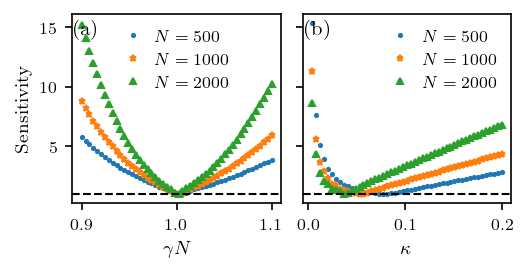

In [671]:

fig, (ax_top, ax_bot) = plt.subplots(
    1, 2, figsize=(3.40457,0.5*3.40457), constrained_layout=True, sharey =True,
)

# ---------- (a) Sensitivity vs γN ----------

ax_top.plot(gamma_vals1 * Nplot[0], Tr_no_resetN1_g / np.min(Tr_no_resetN1_g), '.',markersize = 3,
            label=fr'$N = {int(Nplot[0])}$')


ax_top.plot(gamma_vals2 * Nplot[1], Tr_no_resetN2_g / np.min(Tr_no_resetN2_g), '*',markersize = 3,
            label=fr'$N = {int(Nplot[1])}$')

ax_top.plot(gamma_vals3 * Nplot[2], Tr_no_resetN3_g / np.min(Tr_no_resetN3_g), '^',markersize = 3,
            label=fr'$N = {int(Nplot[2])}$')

ax_top.axhline(1, ls='--', color='k')
ax_top.set_ylabel(r'Sensitivity')
ax_top.legend(frameon=False, loc='best',fontsize = 8)
ax_top.text(0.01, 0.98, '(a)', transform=ax_top.transAxes, ha='left', va='top')
ax_top.set_xlabel(r'$\gamma N$')
# ---------- (a) Sensitivity vs kappa ----------

ax_bot.plot(kappa_vals[1:], Tr_no_resetN1_k / np.min(Tr_no_resetN1_k), '.',markersize = 3,
            label=fr'$N = {int(Nplot[0])}$')


ax_bot.plot(kappa_vals[1:], Tr_no_resetN2_k/ np.min(Tr_no_resetN2_k), '*',markersize = 3,
            label=fr'$N = {int(Nplot[1])}$')


ax_bot.plot(kappa_vals[1:], Tr_no_resetN3_k / np.min(Tr_no_resetN3_k), '^',markersize = 3,
            label=fr'$N = {int(Nplot[2])}$')


ax_bot.legend(frameon=False, loc='best',fontsize = 8)
ax_bot.text(0.01, 0.98, '(b)', transform=ax_bot.transAxes, ha='left', va='top')
ax_bot.axhline(1, ls='--', color='k')
ax_bot.set_xlabel(r'$\kappa$')


# Optional tuning:
# fig.subplots_adjust(hspace=0.15)  # extra vertical space if needed
# for ax in (ax_top, ax_bot): ax.tick_params(axis='y', pad=2)


plt.savefig(r'supplementary_figure2.pdf',bbox_inches = 'tight',transparent = 'True', dpi = 600)
plt.show()

## $r_{\rm opt}$ density plot in the $(\gamma N, \kappa)$ plane 

In [219]:
def compute_survival_and_transition(gg, gamma, kk, kappa, rr, r, Tcutoff, dt, N):
    s_prob = surv_prob_det_reset(Tcutoff, dt, r, N, gamma, kappa)
    T_val = find_transition_point(s_prob, dt, 0.001)
    return (gg, kk, rr, T_val)

# Parameters
Tcutoff = 3600 
dt = 0.05
r_vals = np.linspace(0, (Tcutoff+1)/40/dt, 50, dtype=int)
kappa_vals = np.linspace(0.001, 0.1, 50)
N = 1000  # System size
gamma_vals = np.linspace(0.9/N, 1.1/N, 50)

# Storage Arrays
T_decay0p5 = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals)))

# Create parameter list
param_list = []
for gg, gamma in enumerate(gamma_vals):
    for kk, kappa in enumerate(kappa_vals):
        for rr, r in enumerate(r_vals):
            param_list.append((gg, gamma, kk, kappa, rr, r))

# Run in parallel; here, a value of -1 means that all available cores are used
results = Parallel(n_jobs=-1)(
    delayed(compute_survival_and_transition)(
        gg, gamma, kk, kappa, rr, r, Tcutoff, dt, N
    )
    for (gg, gamma, kk, kappa, rr, r) in tqdm(param_list, desc="Computing", total=len(param_list), disable=False, leave=True)
)

# Place results into arrays
for (gg, kk, rr, T_val) in results:
    T_decay0p5[gg, kk, rr] = T_val

filename = f"../Data/Data_Log/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_reset_density_plot.pkl"
dict_to_save = [gamma_vals, kappa_vals, r_vals, T_decay0p5]
with open(filename, 'wb') as f:
    pickle.dump(dict_to_save, f)

Computing: 100%|██████████| 125000/125000 [56:11<00:00, 37.08it/s]


In [252]:
N =500
filename = f"../Data/Data_Log/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_reset_density_plot.pkl"

with open(filename, 'rb') as f:
    dict_to_read = pickle.load(f)

In [253]:
gamma_vals, kappa_vals, r_vals, T_decay0p5 = dict_to_read

r_optimum = np.zeros((len(gamma_vals),len(kappa_vals)))
Tr_optimum = np.zeros((len(gamma_vals),len(kappa_vals)))



for i in range(len(gamma_vals)):
    for j in range(len(kappa_vals)):
        if T_decay0p5[i][j][0] != np.inf:

            diffs = T_decay0p5[i][j] - T_decay0p5[i][j][0]
            min_j = np.argmin(diffs)
            if diffs[min_j] < diffs[0]:
                k = min_j
            else:
                k = 0
            r_optimum[i][j] = r_vals[k]
            Tr_optimum[i][j] = T_decay0p5[i][j][k]
        
        else:

            r_optimum[i][j] = np.nan
            Tr_optimum[i][j] = np.nan

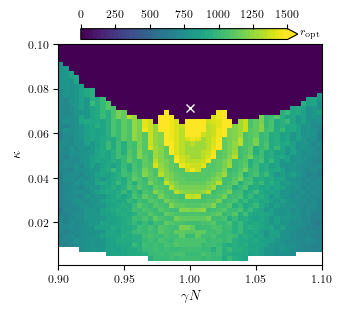

In [254]:

gamma_vals = np.linspace(0.9/N, 1.1/N, 50)
gammaN_axis = gamma_vals * N
kappa_vals = np.linspace(0.001, 0.1, 50)


fig = plt.figure(figsize=(3.40457,0.9*3.40457 ))
#gs = fig.add_gridspec(2, 2, wspace=0.5, hspace=0.35)


im = plt.imshow(
    r_optimum.T, origin="lower", aspect="auto",
    extent=[gammaN_axis[0], gammaN_axis[-1], kappa_vals[0], kappa_vals[-1]],
    cmap=plt.get_cmap("viridis", 50), vmax=1500
)
plt.xlabel(r"$\gamma N$",fontsize = 10)
plt.ylabel(r"$\kappa$",fontsize = 10)
cbar = fig.colorbar(im, ax=plt.gca(), extend="max", pad=0.02, fraction=0.046,location = 'top')
cbar.ax.text(1.06, 0.1, r"$r_{\rm opt}$",
             transform=cbar.ax.transAxes, ha="left", va="bottom", fontsize =8 )

plt.plot(1,1.6/np.sqrt(N), color = 'white', marker = 'x')
#cbar.ax.set_title(r"$T_{\rm decay}^{S(t)=0.5}$",loc="right", pad=2)
#ax_a.text(0.02,0.95 , "(a)", transform=ax_a.transAxes,va="top", ha="left",fontsize =10)

plt.savefig(r'reset_phase_diagram_0.pdf',bbox_inches = 'tight')

In [418]:
(1.0/1.6)*np.log((2*(2+1.6))/((4- 1.6**2)*0.001))/(np.pi/2)

np.float64(3.3888834942063246)

In [241]:
finite_mask = np.isfinite(r_optimum)
if finite_mask.any():
    vmax = np.max(r_optimum[finite_mask])        # same as np.nanmax(r_optimum)
    vmin = np.min(r_optimum[finite_mask])        # same as np.nanmin(r_optimum)
else:
    raise ValueError("r_optimum is all NaN; nothing to plot.")
vmax

np.float64(1800.0)

In [228]:
vmax

np.float64(1800.0)

## Overlaps and eigenvalues density plot as a function of $\gamma N$ and $\kappa$

In [44]:
N = 1000

gamma_vals = np.linspace(0.9/N, 1.1/N, 100)
kappa_vals = np.linspace(0.001, 0.4, 100)

overlap_plus  = np.zeros((len(gamma_vals),len(kappa_vals)))
overlap_minus = np.zeros((len(gamma_vals),len(kappa_vals)))
overlap_pm_real = np.zeros((len(gamma_vals),len(kappa_vals)))
overlap_pm_imag = np.zeros((len(gamma_vals),len(kappa_vals)))

lambda_plus = np.zeros((len(gamma_vals),len(kappa_vals)),dtype = complex)
lambda_minus = np.zeros((len(gamma_vals),len(kappa_vals)),dtype = complex)

for gg in range(len(gamma_vals)):
    for kk in range(len(kappa_vals)):
        overlap_p, overlap_m, overlap_pm = overlap(N,gamma_vals[gg],kappa_vals[kk])
        overlap_plus[gg,kk] = overlap_p
        overlap_minus[gg,kk] = overlap_m
        overlap_pm_real[gg,kk] = np.real(overlap_pm)
        overlap_pm_imag[gg,kk] = np.imag(overlap_pm)

        lambda_plus[gg,kk],lambda_minus[gg,kk] = lambda_pm(N,gamma_vals[gg],kappa_vals[kk])




/tmp/ipykernel_2168259/2860021475.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  overlap_plus[gg,kk] = overlap_p
/tmp/ipykernel_2168259/2860021475.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  overlap_minus[gg,kk] = overlap_m


Text(1.06, 0.1, '$O_+$')

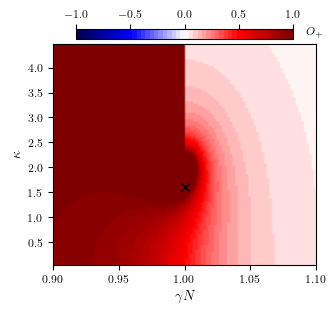

In [451]:

gamma_vals = np.linspace(0.9/N, 1.1/N, 50)
gammaN_axis = gamma_vals * N
kappa_vals = np.linspace(0.001, 0.1, 50)*np.sqrt(N)

fig = plt.figure(figsize=(3.40457,0.9*3.40457 ))
#gs = fig.add_gridspec(2, 2, wspace=0.5, hspace=0.35)


im = plt.imshow(
    overlap_plus.T, origin="lower", aspect="auto",
    extent=[gammaN_axis[0], gammaN_axis[-1], kappa_vals[0], kappa_vals[-1]],
    cmap=plt.get_cmap("seismic", 50), vmax=1,vmin = -1
)

plt.plot(1, 1.6,'x', color = 'k')
plt.xlabel(r"$\gamma N$",fontsize = 10)
plt.ylabel(r"$\kappa$",fontsize = 10)
cbar = fig.colorbar(im, ax=plt.gca(), pad=0.02, fraction=0.046,location = 'top')
cbar.ax.text(1.06, 0.1, r"$O_+$",
             transform=cbar.ax.transAxes, ha="left", va="bottom", fontsize =8 )
#cbar.ax.set_title(r"$T_{\rm decay}^{S(t)=0.5}$",loc="right", pad=2)
#ax_a.text(0.02,0.95 , "(a)", transform=ax_a.transAxes,va="top", ha="left",fontsize =10)

#plt.savefig(r'overlap_plus_N2000.pdf',bbox_inches = 'tight')

Text(1.06, 0.1, '$O_-$')

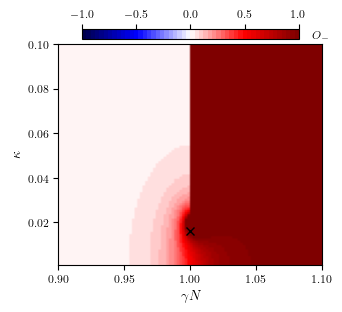

In [447]:

gamma_vals = np.linspace(0.9/N, 1.1/N, 50)
gammaN_axis = gamma_vals * N
kappa_vals = np.linspace(0.001, 0.1, 50)

fig = plt.figure(figsize=(3.40457,0.9*3.40457 ))
#gs = fig.add_gridspec(2, 2, wspace=0.5, hspace=0.35)


im = plt.imshow(
    overlap_minus.T, origin="lower", aspect="auto",
    extent=[gammaN_axis[0], gammaN_axis[-1], kappa_vals[0], kappa_vals[-1]],
    cmap=plt.get_cmap("seismic", 50), vmax=1,vmin =-1,
)

plt.plot(1, 1.6/np.sqrt(N),'x', color = 'k')
plt.xlabel(r"$\gamma N$",fontsize = 10)
plt.ylabel(r"$\kappa$",fontsize = 10)
cbar = fig.colorbar(im, ax=plt.gca(), pad=0.02, fraction=0.046,location = 'top')
cbar.ax.text(1.06, 0.1, r"$O_-$",
             transform=cbar.ax.transAxes, ha="left", va="bottom", fontsize =8 )
#cbar.ax.set_title(r"$T_{\rm decay}^{S(t)=0.5}$",loc="right", pad=2)
#ax_a.text(0.02,0.95 , "(a)", transform=ax_a.transAxes,va="top", ha="left",fontsize =10)

#plt.savefig(r'overlap_minus_N2000.pdf',bbox_inches = 'tight')

Text(1.06, 0.1, 'Re$[O_\\pm]$')

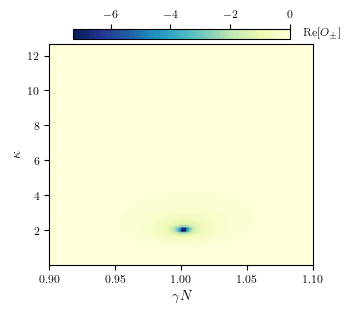

In [45]:

gamma_vals = np.linspace(0.9/N, 1.1/N, 50)
gammaN_axis = gamma_vals * N
kappa_vals = np.linspace(0.001, 0.4, 50)*np.sqrt(N)

fig = plt.figure(figsize=(3.40457,0.9*3.40457 ))
#gs = fig.add_gridspec(2, 2, wspace=0.5, hspace=0.35)


im = plt.imshow(
    overlap_pm_real.T, origin="lower", aspect="auto",
    extent=[gammaN_axis[0], gammaN_axis[-1], kappa_vals[0], kappa_vals[-1]],
    cmap=plt.get_cmap("YlGnBu_r", 50),vmax =0
)


#plt.plot(1, 1.6,'x', color = 'k')
plt.xlabel(r"$\gamma N$",fontsize = 10)
plt.ylabel(r"$\kappa$",fontsize = 10)
cbar = fig.colorbar(im, ax=plt.gca(), pad=0.02, fraction=0.046,location = 'top')
cbar.ax.text(1.06, 0.1, r"Re$[O_\pm]$",
             transform=cbar.ax.transAxes, ha="left", va="bottom", fontsize =8 )
#cbar.ax.set_title(r"$T_{\rm decay}^{S(t)=0.5}$",loc="right", pad=2)
#ax_a.text(0.02,0.95 , "(a)", transform=ax_a.transAxes,va="top", ha="left",fontsize =10)

#plt.savefig(r'overlap_pm_real_N2000.pdf',bbox_inches = 'tight')

array([-1.24661968e-03, -5.02393175e-03, -1.14471342e-02, -2.07180943e-02,
       -3.31416756e-02, -4.91520193e-02, -6.93532266e-02, -9.45820633e-02,
       -1.26005939e-01, -1.65279916e-01, -2.14807160e-01, -2.78190243e-01,
       -3.61056467e-01, -4.72671245e-01, -6.29367013e-01, -8.62651674e-01,
       -1.24122883e+00, -1.94208495e+00, -3.50160878e+00, -5.92863207e+00,
       -3.78573679e+00, -2.21123984e+00, -1.50017944e+00, -1.11624959e+00,
       -8.79361746e-01, -7.19650816e-01, -6.05132408e-01, -5.19247257e-01,
       -4.52604050e-01, -3.99493495e-01, -3.56250388e-01, -3.20416458e-01,
       -2.90282639e-01, -2.64624583e-01, -2.42542634e-01, -2.23361185e-01,
       -2.06563216e-01, -1.91746491e-01, -1.78593487e-01, -1.66850293e-01,
       -1.56311503e-01, -1.46809218e-01, -1.38204899e-01, -1.30383250e-01,
       -1.23247574e-01, -1.16716187e-01, -1.10719636e-01, -1.05198506e-01,
       -1.00101687e-01, -9.53849819e-02, -9.10099876e-02, -8.69431834e-02,
       -8.31551874e-02, -

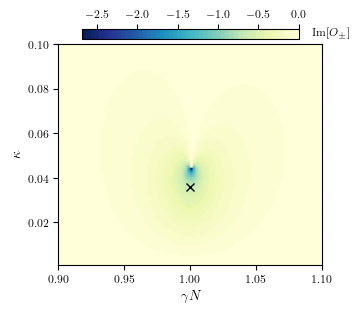

In [303]:

gamma_vals = np.linspace(0.9/N, 1.1/N, 50)
gammaN_axis = gamma_vals * N
kappa_vals = np.linspace(0.001, 0.1, 50)

fig = plt.figure(figsize=(3.40457,0.9*3.40457 ))
#gs = fig.add_gridspec(2, 2, wspace=0.5, hspace=0.35)


im = plt.imshow(
    overlap_pm_imag.T, origin="lower", aspect="auto",
    extent=[gammaN_axis[0], gammaN_axis[-1], kappa_vals[0], kappa_vals[-1]],
    cmap=plt.get_cmap("YlGnBu_r", 50),vmax = 0
)

plt.plot(1, 1.6/np.sqrt(N),'x', color = 'k')
plt.xlabel(r"$\gamma N$",fontsize = 10)
plt.ylabel(r"$\kappa$",fontsize = 10)
cbar = fig.colorbar(im, ax=plt.gca(), pad=0.02, fraction=0.046,location = 'top')
cbar.ax.text(1.06, 0.1, r"Im$[O_\pm]$",
             transform=cbar.ax.transAxes, ha="left", va="bottom", fontsize =8 )
#cbar.ax.set_title(r"$T_{\rm decay}^{S(t)=0.5}$",loc="right", pad=2)
#ax_a.text(0.02,0.95 , "(a)", transform=ax_a.transAxes,va="top", ha="left",fontsize =10)

plt.savefig(r'overlap_pm_imag_N2000.pdf',bbox_inches = 'tight')

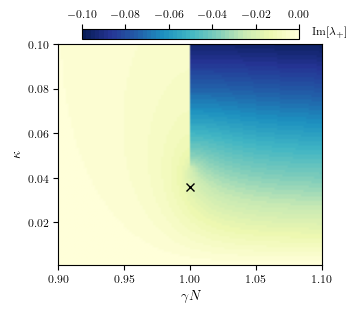

In [304]:

gamma_vals = np.linspace(0.9/N, 1.1/N, 50)
gammaN_axis = gamma_vals * N
kappa_vals = np.linspace(0.001, 0.1, 50)

fig = plt.figure(figsize=(3.40457,0.9*3.40457 ))
#gs = fig.add_gridspec(2, 2, wspace=0.5, hspace=0.35)


im = plt.imshow(
    np.imag(lambda_plus).T, origin="lower", aspect="auto",
    extent=[gammaN_axis[0], gammaN_axis[-1], kappa_vals[0], kappa_vals[-1]],
    cmap=plt.get_cmap("YlGnBu_r", 50),vmin = -0.1, vmax =0
)

plt.plot(1, 1.6/np.sqrt(N),'x', color = 'k')
plt.xlabel(r"$\gamma N$",fontsize = 10)
plt.ylabel(r"$\kappa$",fontsize = 10)
cbar = fig.colorbar(im, ax=plt.gca(),  pad=0.02, fraction=0.046,location = 'top')
cbar.ax.text(1.06, 0.1, r"Im$[\lambda_+]$",
             transform=cbar.ax.transAxes, ha="left", va="bottom", fontsize =8 )
#cbar.ax.set_title(r"$T_{\rm decay}^{S(t)=0.5}$",loc="right", pad=2)
#ax_a.text(0.02,0.95 , "(a)", transform=ax_a.transAxes,va="top", ha="left",fontsize =10)

plt.savefig(r'lambda_plus_N2000.pdf',bbox_inches = 'tight')

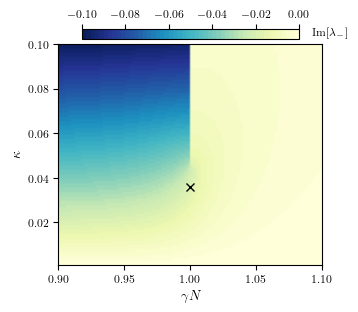

In [305]:

gamma_vals = np.linspace(0.9/N, 1.1/N, 50)
gammaN_axis = gamma_vals * N
kappa_vals = np.linspace(0.001, 0.1, 50)

fig = plt.figure(figsize=(3.40457,0.9*3.40457 ))
#gs = fig.add_gridspec(2, 2, wspace=0.5, hspace=0.35)


im = plt.imshow(
    np.imag(lambda_minus).T, origin="lower", aspect="auto",
    extent=[gammaN_axis[0], gammaN_axis[-1], kappa_vals[0], kappa_vals[-1]],
    cmap=plt.get_cmap("YlGnBu_r", 50),vmin = -0.1, vmax =0
)
plt.xlabel(r"$\gamma N$",fontsize = 10)
plt.ylabel(r"$\kappa$",fontsize = 10)
cbar = fig.colorbar(im, ax=plt.gca(),  pad=0.02, fraction=0.046,location = 'top')
cbar.ax.text(1.06, 0.1, r"Im$[\lambda_-]$",
             transform=cbar.ax.transAxes, ha="left", va="bottom", fontsize =8 )

plt.plot(1, 1.6/np.sqrt(N),'x', color = 'k')
#cbar.ax.set_title(r"$T_{\rm decay}^{S(t)=0.5}$",loc="right", pad=2)
#ax_a.text(0.02,0.95 , "(a)", transform=ax_a.transAxes,va="top", ha="left",fontsize =10)

plt.savefig(r'lambda_minus_N2000.pdf',bbox_inches = 'tight')

Text(1.06, 0.1, '$\\textrm{Re}[\\lambda_+] - \\textrm{Re}[\\lambda_-]$')

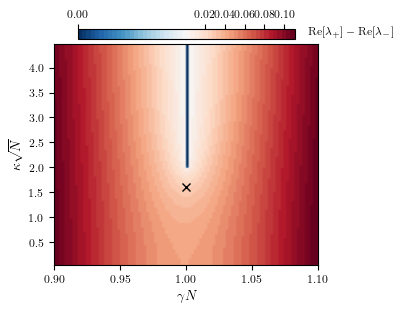

In [18]:
import matplotlib.colors as mcolors
gamma_vals = np.linspace(0.9/N, 1.1/N, 50)
gammaN_axis = gamma_vals * N
kappa_vals = np.linspace(0.001, 0.1, 50) *np.sqrt(N)

fig = plt.figure(figsize=(3.40457,0.9*3.40457 ))
#gs = fig.add_gridspec(2, 2, wspace=0.5, hspace=0.35)



cmap = plt.get_cmap('RdBu_r',50)

norm = mcolors.TwoSlopeNorm(vmin= 0, vmax=np.max(np.real(lambda_plus) - np.real(lambda_minus)), vcenter= 10e-4 )

im = plt.imshow(
   (np.real(lambda_plus) - np.real(lambda_minus)).T, origin="lower", aspect="auto",
    extent=[gammaN_axis[0], gammaN_axis[-1], kappa_vals[0], kappa_vals[-1]],cmap=cmap, norm=norm
)
plt.xlabel(r"$\gamma N$",fontsize = 10)
plt.ylabel(r"$\kappa \sqrt{N} $",fontsize = 10)

plt.plot(1, 1.6,'x', color = 'k')


cbar = fig.colorbar(im, ax=plt.gca(), pad=0.02, fraction=0.046,location = 'top')
cbar.ax.text(1.06, 0.1, r"$\textrm{Re}[\lambda_+] - \textrm{Re}[\lambda_-]$",
             transform=cbar.ax.transAxes, ha="left", va="bottom", fontsize =8 )
#cbar.ax.set_title(r"$T_{\rm decay}^{S(t)=0.5}$",loc="right", pad=2)
#ax_a.text(0.02,0.95 , "(a)", transform=ax_a.transAxes,va="top", ha="left",fontsize =10)

#plt.savefig(r'reset_phase_diagram.pdf',bbox_inches = 'tight')

In [15]:
np.max(np.real(lambda_plus) - np.real(lambda_minus))

np.float64(0.11045271273967339)